## Hierarchical Reinforcement Learning

For this assignment, we will be referring to Sutton, Precup and Singh’s 1999 paper, ‘Between MDPs and semi-MDPs : A Framework for Temporal Abstraction in Reinforcement Learning’. Please read the paper upto and including Section 3, it is self explanatory and a
good reference leading up to the understanding and implementation of SMDP Q-learning. Section 3 of the paper talks about SMDP planning and is necessary to build intuition to solve this assignment. We will be working with a simple taxi domain environment (explained
in the next section). Your tasks are to implement 1-step SMDP Q-Learning and intra-option Q-Learning on this environment.

##  Environment Description
The environment for this task is the taxi domain, illustrated in Fig. 1. It is a 5x5 matrix, where each cell is a position your taxi can stay at. There is a single passenger who can be either picked up or dropped off, or is being transported. There are four designated
locations in the grid world indicated by R(ed), G(reen), Y(ellow), and B(lue). When the episode starts, the taxi starts off at a random square and the passenger is at a random location. The taxi drives to the passenger’s location, picks up the passenger, drives to the
passenger’s destination (another one of the four specified locations), and then drops off the passenger. Once the passenger is dropped off, the episode ends.


There are 500 discrete states since there are 25 taxi positions, 5 possible locations of the passenger (including the case when the passenger is in the taxi), and 4 destination locations. Note that there are 400 states that can actually be reached during an episode. The missing states correspond to situations in which the passenger is at the same location as their destination, as this typically signals the end of an episode. Four additional states can be observed right after a successful episodes, when both the passenger and the taxi are at the destination. This gives a total of 404 reachable discrete states.


Passenger locations: 0: R(ed); 1: G(reen); 2: Y(ellow); 3: B(lue); 4: in taxi Destinations: 0: R(ed); 1: G(reen); 2: Y(ellow); 3: B(lue)
Rewards:
 - -1 per step unless other reward is triggered.
 -  +20 delivering passenger.
 - -10 executing ”pickup” and ”drop-off” actions illegally.
The discount factor is taken to be γ = 0.9.

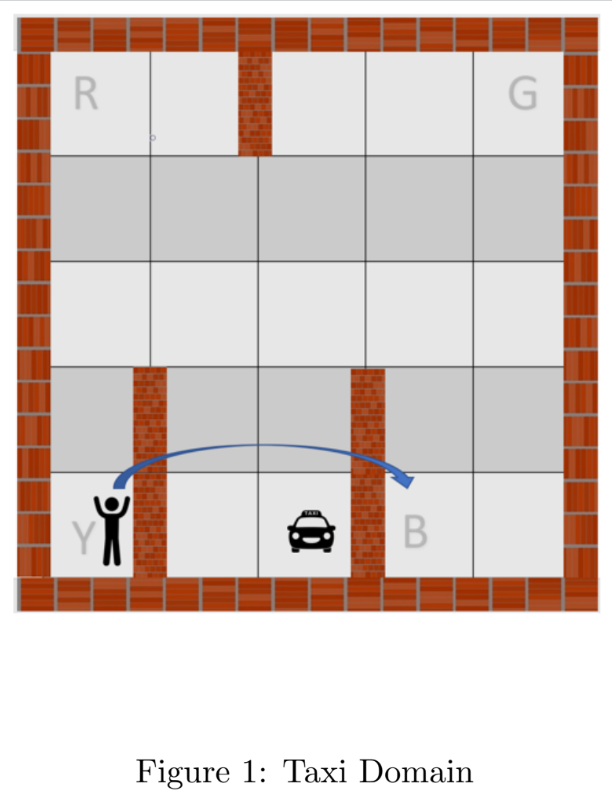

## Actions and Options
**Actions:** There are 6 discrete deterministic actions: 0: move south; 1: move north; 2: move east; 3: move west; 4: pick passenger up; and 5: drop passenger off.


**Options:** Options to move the taxi to each of the four designated locations, executable when the taxi is not already there.


You will be experimenting with OpenAI Gym’s Taxi-v3 environment.

## Tasks
First, implement the single step **SMDP Q-learning** for solving the taxi problem. A rough sketch of the algorithm is as follows: Given the set of options,

- Execute the current selected option to termination (e.g. use epsilon greedy $Q(s, o))$.
- Computer $r(s, o)$.
- Update $Q(st, o)$.

Second, implement **intra-option Q-Learning** on the same environment.


For each algorithm, do the following (only for the configuration with the best hyperparameters):

1. Plot reward curves and visualize the learned Q-values.
2. Provide a written description of the policies learnt and your reasoning behind why
the respective algorithm learns the policy.

3. Is there an alternate set of options that you can use to solve this problem, such that this set and the given options to move the taxi are mutually exclusive? If so, run both algorithms with this alternate set of options and compare performance with the algorithms run on the options to move the taxi.


Finally, provide a comparison between the SMDP Q-Learning and intra-option Q-Learning algorithms. Do you observe any improvement with intra-option Q-Learning? If so, describe why this happens as well. Please make sure that all descriptions are brief and to the point.

## Submission Instructions
You are required to submit both your report and your code. Zip your code (a colab/jupyter notebook ipynb file) and report (a pdf file) together and submit.

In [1]:
# Installing the gymnasium environment
# !pip install gymnasium

In [2]:
# Importing important libraries
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import seaborn as sns
from tqdm import tqdm
# Setting the seed
np.random.seed(45)

In [3]:
# environment setup
env = gym.make('Taxi-v3')
# Number of actions
num_actions = env.action_space.n

## Defining the optimal policies for premetive location and New Location 
1. Premetive Location
2. new Location

### For premetive Locations

In [4]:
def pass_loc_R(env, state):
    done = False
    taxi_row, taxi_col, pass_loc, dest_loc = env.unwrapped.decode(state)

# actions: {0: 'south', 1: 'north', 2: 'east', 3: 'west'}
    optimal_act = 1 # north

    if taxi_col == 0:
        optimal_act = 1 # north
        if taxi_row == 0:
            done = True        
    elif taxi_row > 2 and taxi_col >= 1:
        optimal_act = 1 # north
    elif taxi_row == 2 and taxi_col >= 1:
        optimal_act = 3 # west
    elif taxi_row < 2 and taxi_col >= 2:
        optimal_act = 0 # south
    elif taxi_row <= 1 and taxi_col == 1:
        optimal_act = 3 # west 
    
    return (optimal_act, done)

# Going to location G for dropping the passanger
def pass_loc_G(env, state):
    done = False
    taxi_row, taxi_col, pass_loc, dest_loc = env.unwrapped.decode(state)

    optimal_act = 2 # move east
    # if taxi_row == 0 and taxi_col == 4:
    #     done = True
    if taxi_col == 4:
        optimal_act = 1 # north
        if taxi_row == 0:
            done = True

    elif taxi_row >= 3 and taxi_col < 4:
        optimal_act = 1 # north
    elif taxi_row < 2 and taxi_col < 2:
        optimal_act = 0 # south
    elif taxi_row < 2 and 2 <= taxi_col < 4:
        optimal_act = 2 # east
    elif taxi_row == 2 and taxi_col <4 :
        optimal_act = 2 # east

    return (optimal_act, done)


# Going to location Y for picking the passanger
def pass_loc_Y(env, state):
    done = False
    taxi_row, taxi_col, pass_loc, dest_loc = env.unwrapped.decode(state)

    optimal_act = 0 # south

    if taxi_col == 0:
        optimal_act = 0
        if taxi_row == 4:
            done = True

    elif taxi_row > 2 and taxi_col >= 1:
        optimal_act = 1 # north
    elif taxi_row == 2 and taxi_col >= 1:
        optimal_act = 3 # west
    elif taxi_row < 2 and taxi_col >= 1:
        optimal_act = 0
    

    return (optimal_act, done)

# Going to location B 
def pass_loc_B(env, state):
    done = False
    taxi_row, taxi_col, pass_loc, dest_loc = env.unwrapped.decode(state)

    optimal_act = 0 # south

    if taxi_col == 3:
        optimal_act = 0 # south
        if taxi_row == 4:
            done = True

    elif taxi_col == 4:
        optimal_act = 3 # west
    elif taxi_row <=1 and taxi_col < 3:
        optimal_act = 0 # south
    elif taxi_row >= 3 and taxi_col < 3:
        optimal_act = 1 # north
    elif taxi_row == 2 and taxi_col < 3:
        optimal_act = 2 # east


    return (optimal_act, done)

### For New Locations

In [5]:
# taking the new destination for the passanger (0,1), (3,1), (0,3) and (3,3)
# writning the policy for the new destination 

def new_pass_loc_A(env, state):
    # for the new destination (0,1)
    done = False
    taxi_row, taxi_col, pass_loc, dest_loc = env.unwrapped.decode(state)

    optimal_act = 1 # north

    if taxi_col == 1:
        optimal_act = 1
        if taxi_row == 0:
            done = True
    elif taxi_col ==0:
        if taxi_row <= 2:
            optimal_act = 2
        else:
            optimal_act = 1

    elif taxi_col==2:
        if taxi_row < 2:
            optimal_act = 0
        else:
            optimal_act = 3
    
    elif taxi_col==3:
        if taxi_row <= 2:
            optimal_act = 3
        else:
            optimal_act = 1

    elif taxi_col==4:
        optimal_act = 3
    
    return (optimal_act, done)

def new_pass_loc_B(env, state):
    # for the new destination (3,1)
    done = False
    taxi_row, taxi_col, pass_loc, dest_loc = env.unwrapped.decode(state)

    optimal_act = 3 # west

    if taxi_col == 1:
        if taxi_row == 3:
            done = True
        elif taxi_row < 3:
            optimal_act = 0
        elif taxi_row > 3:
            optimal_act = 1
    
    elif taxi_col == 0:
        if taxi_row <= 2:
            optimal_act = 2
        else:
            optimal_act = 1

    elif taxi_col == 2:
        if taxi_row < 2:
            optimal_act = 0
        else:
            optimal_act = 3

    elif taxi_col == 3:
        if taxi_row <= 2:
            optimal_act = 3
        else:
            optimal_act = 1
    elif taxi_col == 4:
        optimal_act = 3


    return (optimal_act, done)

def new_pass_loc_C(env, state):
    # for the new destination (0,3)
    done = False
    taxi_row, taxi_col, pass_loc, dest_loc = env.unwrapped.decode(state)

    optimal_act = 1 # north


    if taxi_col == 3:

        if taxi_row == 0:
            done = True
        else:
            optimal_act = 1
    
    elif taxi_col == 0:
        if taxi_row <= 2:
            optimal_act = 2
        else:
            optimal_act = 1

    elif taxi_col == 1:
        if taxi_row < 2:
            optimal_act = 0
        else:
            optimal_act = 2

    elif taxi_col == 2:
        if taxi_row <= 2:
            optimal_act = 2
        else:
            optimal_act = 1

    elif taxi_col == 4:
        optimal_act = 3

    return (optimal_act, done)

def new_pass_loc_D(env, state):
    # for the new destination (3,3)
    done = False
    taxi_row, taxi_col, pass_loc, dest_loc = env.unwrapped.decode(state)

    optimal_act = 3 # north


    if taxi_col == 3:
        if taxi_row == 3:
            done = True
        elif taxi_row < 3:
            optimal_act = 0
        elif taxi_row > 3:
            optimal_act = 1
    
    elif taxi_col == 0:
        if taxi_row <= 2:
            optimal_act = 2
        else:
            optimal_act = 1

    elif taxi_col == 1:
        if taxi_row < 2:
            optimal_act = 0
        else:
            optimal_act = 2

    elif taxi_col == 2:
        if taxi_row <= 2:
            optimal_act = 2
        else:
            optimal_act = 1
            
    elif taxi_col == 4:
        optimal_act = 3

    return (optimal_act, done)


## Defined Function


### Epsilon Greedy


In [6]:
# Epsilon Greedy Policy
def epsilon_greedy_policy(Q, state, epsilon):
    if np.random.uniform(0, 1) < epsilon:
        return np.random.choice(num_actions) # choosing the random action
    else:
        return np.argmax(Q[state, :]) # choosing the action with the highest Q value
    

### Primitive Optional Actions

In [7]:
def prim_optional_actions(action, state):
    if action == 6:
        optimal_action, opt_done = pass_loc_R(env, state)
              
    elif action == 7:
        optimal_action, opt_done = pass_loc_G(env, state)
    elif action == 8:
        optimal_action, opt_done = pass_loc_Y(env, state)
    elif action == 9:
        optimal_action, opt_done = pass_loc_B(env, state)
    
    return optimal_action, opt_done

### New Optional Actions

In [8]:
def new_optional_actions(action, state):
    if action == 6:
        optimal_action, opt_done = new_pass_loc_A(env, state)
    elif action == 7:
        optimal_action, opt_done = new_pass_loc_C(env, state)
    elif action == 8:
        optimal_action, opt_done = new_pass_loc_B(env, state)
    elif action == 9:
        optimal_action, opt_done = new_pass_loc_D(env, state)
        
    return optimal_action, opt_done

### Updating the Q Values

In [9]:
def prim_Q_val_update(Q, state, action, next_state, reward, alpha, gamma):

    td = reward + gamma * np.max(Q[next_state,:]) - Q[state, action]
    Q[state][action] += alpha * td

# optional Q value update with discounted_reward
def option_Q_val_update(Q, state, action, next_state, discounted_reward, tau, alpha, gamma):

    td = discounted_reward + (gamma ** tau) * np.max(Q[next_state,:]) - Q[state, action]
    Q[state, action] += alpha * td

def option_Q_val_update_done(Q, state, action, next_state, reward, alpha, done):
    
    td = reward + ((1-done) * Q[next_state, action] + done * np.max(Q[next_state])) - Q[state, action]
    Q[state, action] += alpha * td

## Common Function for Q value for SMDP and intra Q Learning

In [10]:
def Q_learning(env, num_episodes, alpha, gamma, epsilon, type_option, learning_type):
    # Initialize the Q-table
    Q = np.zeros((env.observation_space.n, 10))
    
    # Initialize the rewards list
    rewards = np.zeros(num_episodes)
    
    # Loop through the episodes
    for episode in tqdm(range(num_episodes)):
        # Initialize the total reward for the episode
        cummulative_reward = 0
        
        # Reset the environment to get the start state
        state = env.reset()[0]
        
        # Initialize the done variable to False
        done = False
        
        # Loop through the steps
        while not done:
            intial_state = state
            
            # Choose an action using the epsilon-greedy policy
            choosed_action = epsilon_greedy_policy(Q, state, epsilon)
            
            if choosed_action < 6:
                next_state, reward, done, _, _ = env.step(choosed_action)
                cummulative_reward += reward

                prim_Q_val_update(Q, state, choosed_action, next_state, reward, alpha, gamma)
                state = next_state
                
            else:
                opt_done = False
                time_step = 0
                discounted_reward = 0

                while not opt_done and not done:
                    if type_option == 'provided_option':
                        optimal_action, opt_done = prim_optional_actions(choosed_action, state)

                    else:
                        optimal_action, opt_done = new_optional_actions(choosed_action, state)

                    next_state, reward, done, _, _ = env.step(optimal_action)
                    cummulative_reward += reward

                    if learning_type == 'SMDP':
                        discounted_reward += (gamma ** time_step) * reward
                        time_step += 1

                        if done or opt_done:
                            option_Q_val_update(Q, intial_state, choosed_action, next_state, discounted_reward, time_step, alpha, gamma)

                    elif learning_type == 'intra':
                        prim_Q_val_update(Q, state, choosed_action, next_state, reward, alpha, gamma)
                        option_Q_val_update_done(Q, state, choosed_action, next_state, reward, alpha, opt_done)

                        _, taxi_col, _, _ = env.unwrapped.decode(state)

                        for option in range(6, 10):
                            if option != choosed_action:
                                if type_option == 'provided_option':
                                    # Condition for provided_option
                                    if ((choosed_action in [6, 8] and taxi_col > 0) or 
                                        (choosed_action in [7, 9] and taxi_col < 3)):
                                        optimal_action_, opt_done_ = prim_optional_actions(option, state)

                                        if optimal_action_ == optimal_action_:
                                            option_Q_val_update_done(Q, state, option, next_state, reward, alpha, opt_done_)

                                else:
                                    # Condition for new_option
                                    if ((choosed_action in [6, 8] and (taxi_col < 1 or taxi_col > 1)) or 
                                        (choosed_action in [7, 9] and (taxi_col < 3 or taxi_col > 3))):
                                        optimal_action_, opt_done_ = new_optional_actions(option, state)

                                        if optimal_action_ == optimal_action_:
                                            option_Q_val_update_done(Q, state, option, next_state, reward, alpha, opt_done_)

                    state = next_state

        rewards[episode] = cummulative_reward
    return Q, rewards


### Visualizing the Q Values

In [11]:
def vis_Q_smdp_intra(location, subtitle, env, Q, merger_actions, pass_loc):
    mat_Q_max = np.max(Q, axis=1)  # Getting the maximum Q value for each state
    mat_Q_index = np.argmax(Q, axis=1)  # Getting the index of the maximum Q value for each state
    
    # Create a matrix map for merged actions with labels
    mat_map = np.vectorize(merger_actions.get)(mat_Q_index)
        
    # Indices for the passenger location
    indices = np.arange(20)
    passenger_outside_taxi_indices = indices[location * 4 : location * 4 + 4]
    passenger_inside_taxi_indices = indices[16:20]

    # Function to plot heatmaps
    def plot_heatmaps(axs, indices, title_prefix):
        for n, i in enumerate(indices):
            decoded = list(env.unwrapped.decode(i))  # Convert to list to avoid subscript error
            passenger_loc = decoded[2] if title_prefix != 'Inside Taxi' else None
            destination = decoded[3]

            axs[0][n].set_title(f'{title_prefix} - Passenger Location: {pass_loc[passenger_loc] if passenger_loc is not None else "Inside Taxi"}\nDestination: {pass_loc[destination]}')

            sns.heatmap(mat_Q_max[i::20].reshape(5, 5), annot=True, ax=axs[0][n])
            ant = mat_map[i::20].reshape(5, 5)
            sns.heatmap(mat_Q_index[i::20].reshape(5, 5), annot=ant, fmt='', ax=axs[1][n], cbar=False, cmap="Pastel1")
            axs[1][n].set_title(f'{title_prefix} - Learned Policy: Destination: {pass_loc[destination]}')

    # Create subplots for visualization when the passenger is outside the taxi
    fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(25, 10))
    plt.suptitle(f'{subtitle}', fontsize=14)
    plot_heatmaps(axs, passenger_outside_taxi_indices, 'Outside Taxi')
    
    # Create subplots for visualization when the passenger is inside the taxi
    if location == 3:
        fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(25, 10))
        plt.suptitle(f'{subtitle} - Inside Taxi', fontsize=14)
        plot_heatmaps(axs, passenger_inside_taxi_indices, 'Inside Taxi')

    plt.show()


### Reward Vs Episode 

In [12]:
def reward_vs_episodes(rewards, subtitle, num_episodes):
    # Create a plot for the rewards vs episodes
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(num_episodes), rewards, label='Reward per Episode')

    # Set the title and super title
    plt.title(f'Total Reward per Episode \nMean Reward: {np.mean(rewards):.2f}', fontsize=12)
    plt.suptitle(f'{subtitle}', fontsize=14, y=1.02)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.grid(True)
    plt.legend()



### Average Reward

In [13]:
def average_reward(rewards,  title, num_episodes):
    # Calculate the average reward
    plt.figure(figsize=(10, 6))

    # moving average of rewards over a window of 200 episodes
    mov_avg = [np.average(rewards[i:i+200]) for i in range(len(rewards)-200)]

    plt.plot(mov_avg, label='Moving Average Reward')
    # Set the title and super title
    plt.title(f'Moving Average Reward over 200 Episodes', fontsize=14)
    plt.suptitle(f'{title}', fontsize=14, y=1.02)

    plt.xlabel('Episode')
    plt.ylabel('Average Reward over 200 Episodes')

    plt.grid(True)

    plt.legend()


### Camparision of Average Rewards of SMDP and Intra Q Learning

In [14]:
# plotting the graph for average SMDP and Intra Q-learning rewards over 200 episodes for the best hyperparameters for comparison
def average_rewards_comp(rewards_smdp,  rewards_intra_Q, num_episodes):
    # Calculate the average reward
    plt.figure(figsize=(10, 6))

    # moving average of rewards over a window of 200 episodes
    mov_avg_smdp = [np.average(rewards_smdp[i:i+200]) for i in range(len(rewards_smdp)-200)]

    mov_avg_intra = [np.average(rewards_intra_Q[i:i+200]) for i in range(len(rewards_intra_Q)-200)]
    # Plot the moving average of the rewards for SMDP and Intra Q-learning
    plt.plot(mov_avg_smdp, label='SMDP Q-learning')
    plt.plot(mov_avg_intra, label='Intra Q-learning')

    # Set the title and super title
    plt.title(f'Moving Average Reward over 200 Episodes', fontsize=14)
    plt.suptitle(f'Comparision of SMDP Q-Learing and Intra Q-Learning', fontsize=14, y=1.02)
    # Set the x and y labels
    plt.xlabel('Episode')
    plt.ylabel('Average Rewards of SMDP and Intra Q-Learning over 200 Episodes')
    # grid lines
    plt.grid(True)
    # Show the legend
    plt.legend()



## Finding the Best Hyperparameters for SMDP and Intra Q learning

In [15]:
def best_hyperparameters(env, num_episodes, alpha, gamma, epsilon, type_option, learning_algorith):
  
    best_alpha = float
    best_epsilon = float
    best_mean_reward = -np.inf

    # Loop through the hyperparameters
    for i in alpha:
        for j in epsilon:
            # Run the SMDP Q-learning algorithm
            if learning_algorith == 'SMDP':
                Q_smdp, rewards = Q_learning(env, num_episodes, i, gamma, j, type_option, 'SMDP')
                mean_reward = np.mean(rewards)
                if mean_reward > best_mean_reward:
                    best_mean_reward = mean_reward
                    best_alpha = i
                    best_epsilon = j
            
            # Run the Intra Q-learning algorithm
            else:
                Q_intra, rewards = Q_learning(env, num_episodes, i, gamma, j, type_option, 'intra')
                mean_reward = np.mean(rewards)
                if mean_reward > best_mean_reward:
                    best_mean_reward = mean_reward
                    best_alpha = i
                    best_epsilon = j

    return best_alpha, best_epsilon


## Q-1 Finding the best Parameters for Primitive Options and then plotting the Reward curves for SMDP and Intra Q Learning

### For Primitive Policies 

In [16]:
alpha = [0.001, 0.01,0.1, 1]
gamma = 0.9
epsilon = [0.001,0.01, 0.05, 0.1]
num_episodes = 10000
# environment setup
env = gym.make('Taxi-v3')

# finding the best hyperparameters for SMDP Q-learning
best_alpha_smdp, best_epsilon_smdp = best_hyperparameters(env, num_episodes, alpha, gamma, epsilon, 'provided_option', 'SMDP')
print(f'Best alpha for SMDP Q-learning: {best_alpha_smdp}')
print(f'Best epsilon for SMDP Q-learning: {best_epsilon_smdp}')

# finding the best hyperparameters for Intra Q-learning
best_alpha_intra, best_epsilon_intra = best_hyperparameters(env, num_episodes, alpha, gamma, epsilon, 'provided_option', 'intra')
print(f'Best alpha for Intra Q-learning: {best_alpha_intra}')
print(f'Best epsilon for Intra Q-learning: {best_epsilon_intra}')

100%|██████████| 10000/10000 [00:02<00:00, 3368.32it/s]


Best alpha for SMDP Q-learning: 1
Best epsilon for SMDP Q-learning: 0.001


100%|██████████| 10000/10000 [00:04<00:00, 2417.87it/s]

Best alpha for Intra Q-learning: 1
Best epsilon for Intra Q-learning: 0.001


### Ploting the Curvers for SMDP Q Learning

In [17]:
Q_smdp, rewards_smdp = Q_learning(env, num_episodes, best_alpha_smdp, gamma, best_epsilon_smdp, 'provided_option', 'SMDP')

100%|██████████| 10000/10000 [00:02<00:00, 3622.22it/s]


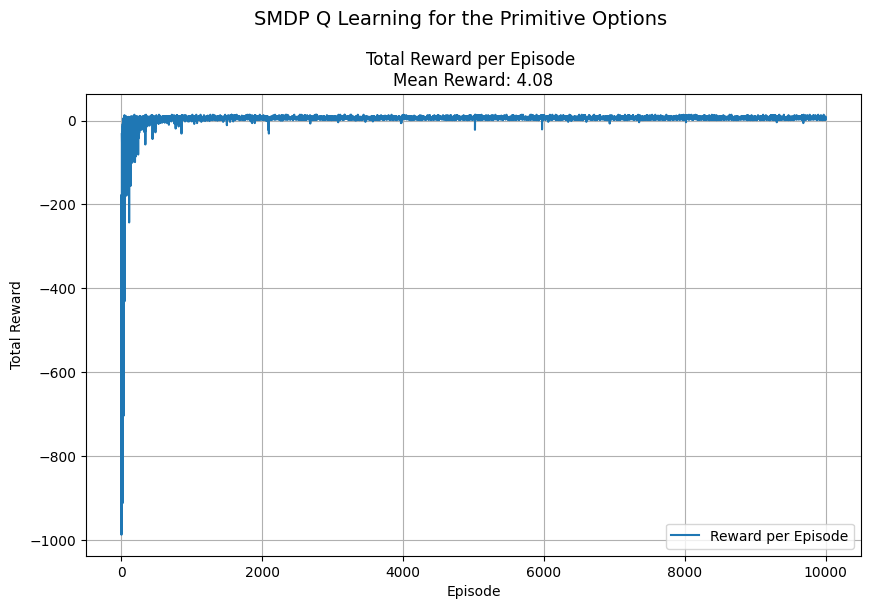

In [38]:
# Reward vs Episodes for SMDP Q-learning
reward_vs_episodes(rewards_smdp, 'SMDP Q Learning for the Primitive Options', num_episodes)

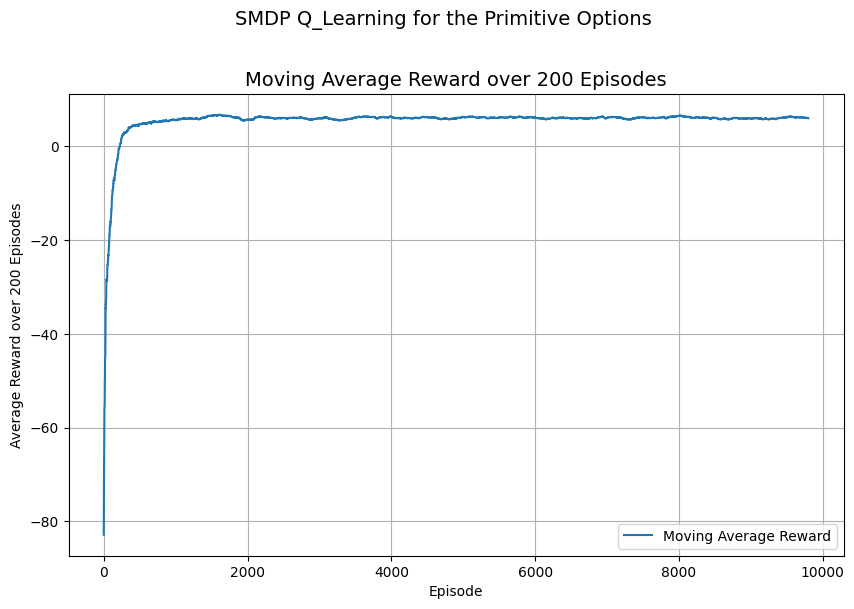

In [39]:
# Moving Average Reward for SMDP Q-learning
average_reward(rewards_smdp, 'SMDP Q_Learning for the Primitive Options', num_episodes)

### Q Values Plots for SMDP Q Learning for primitive policies 

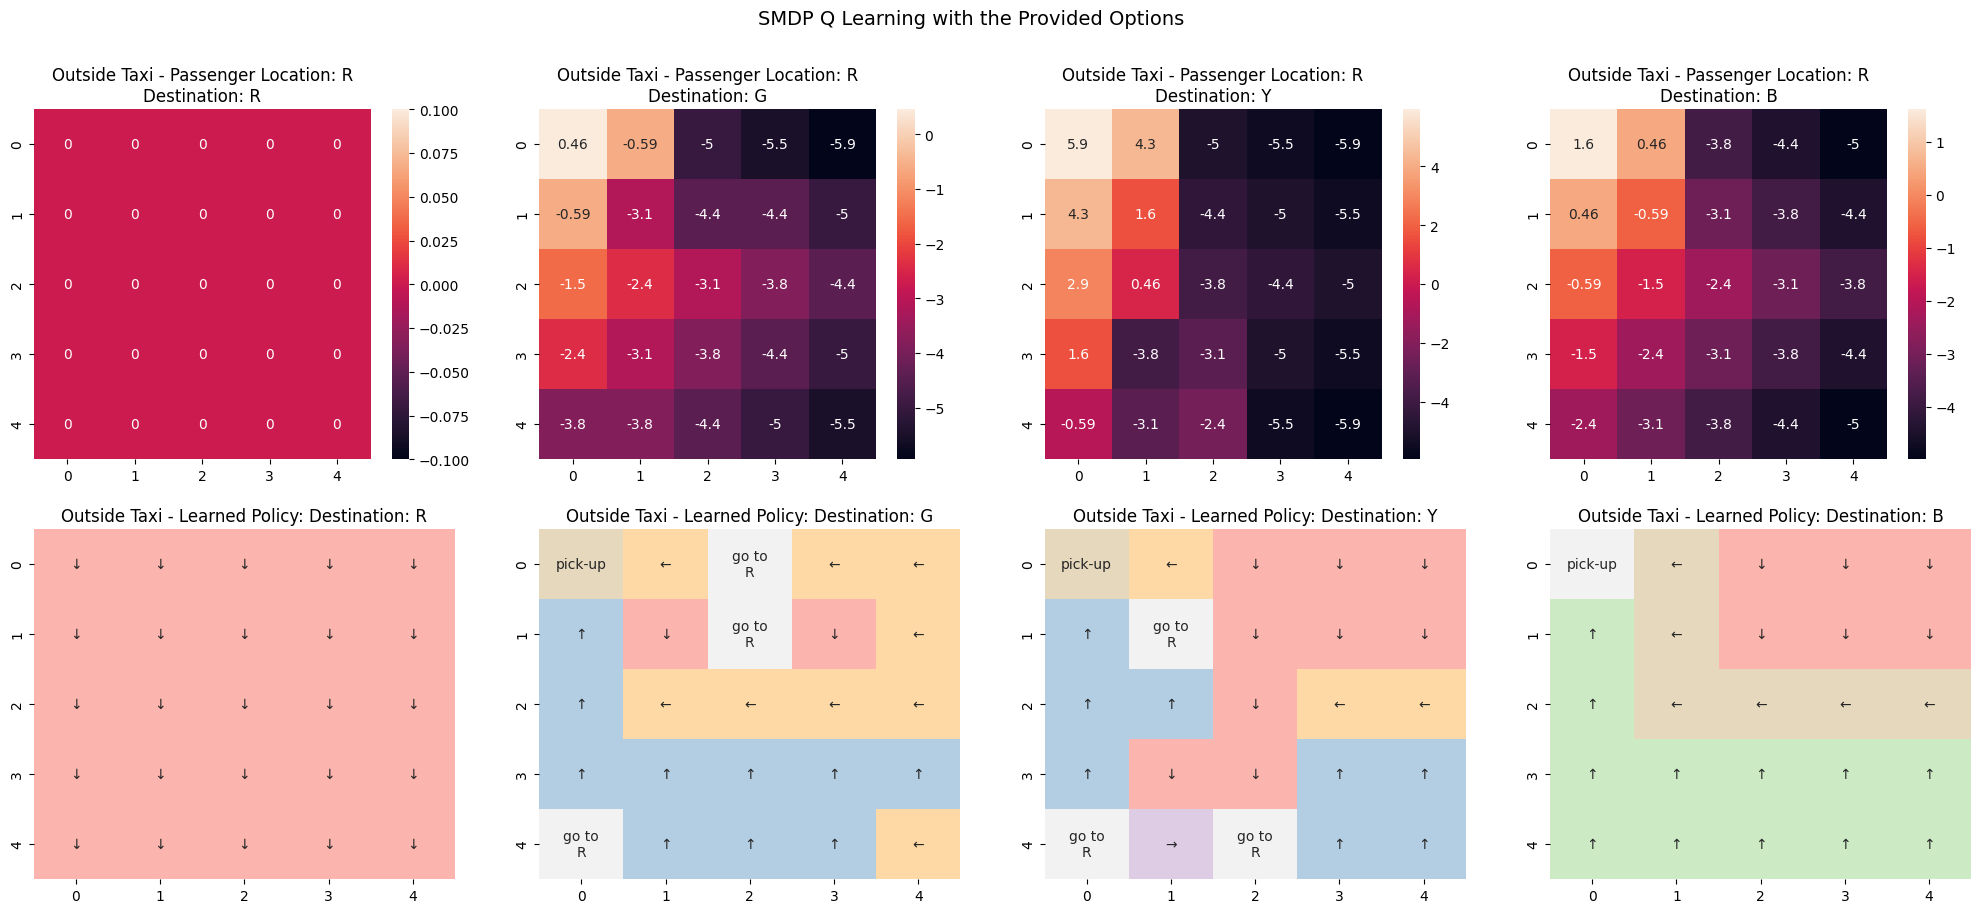

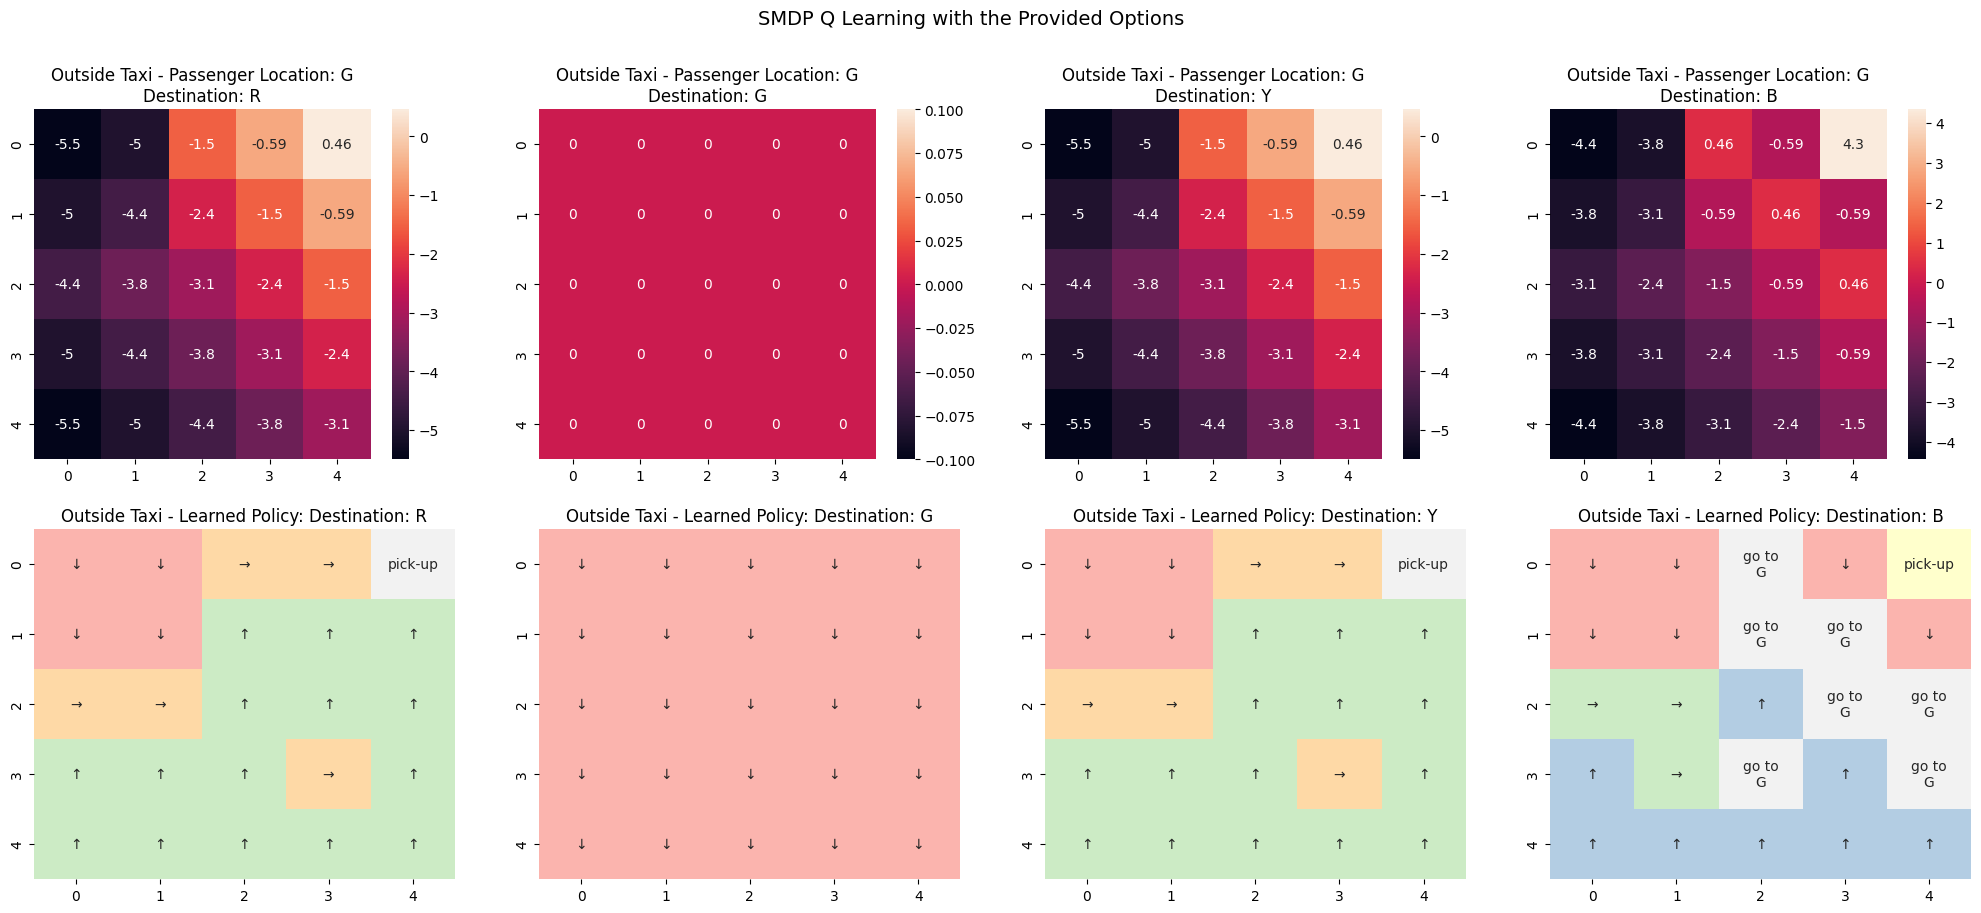

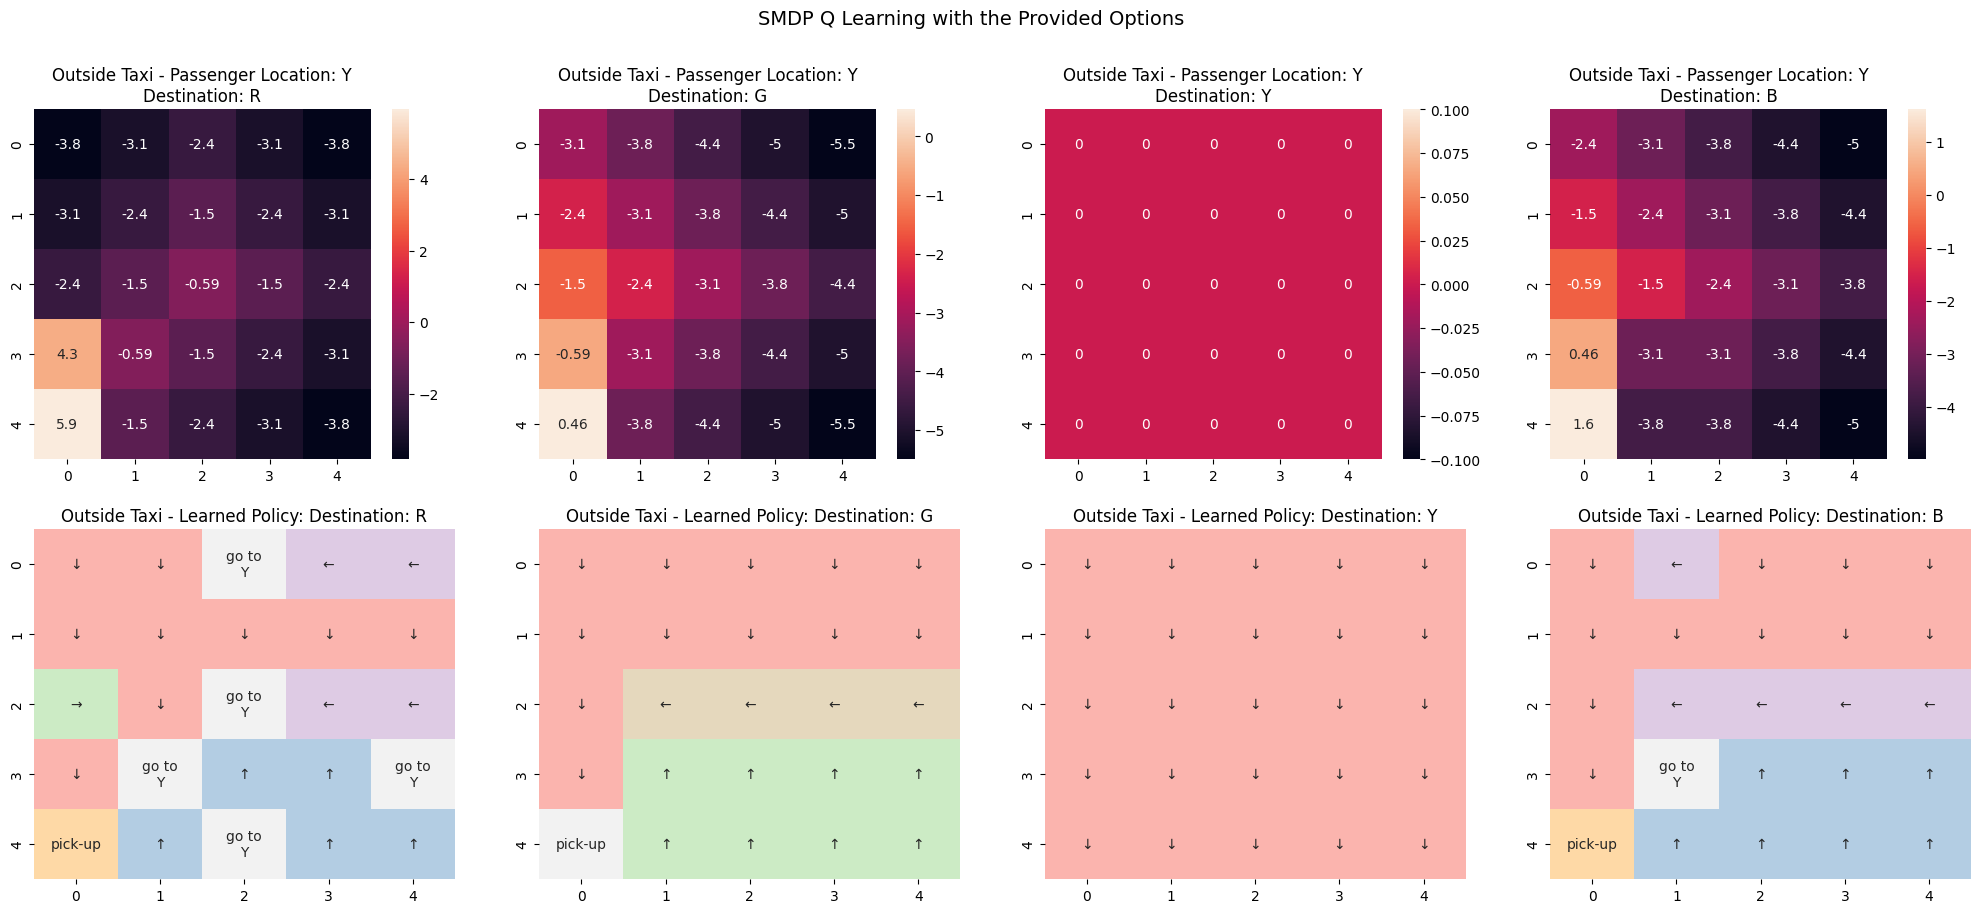

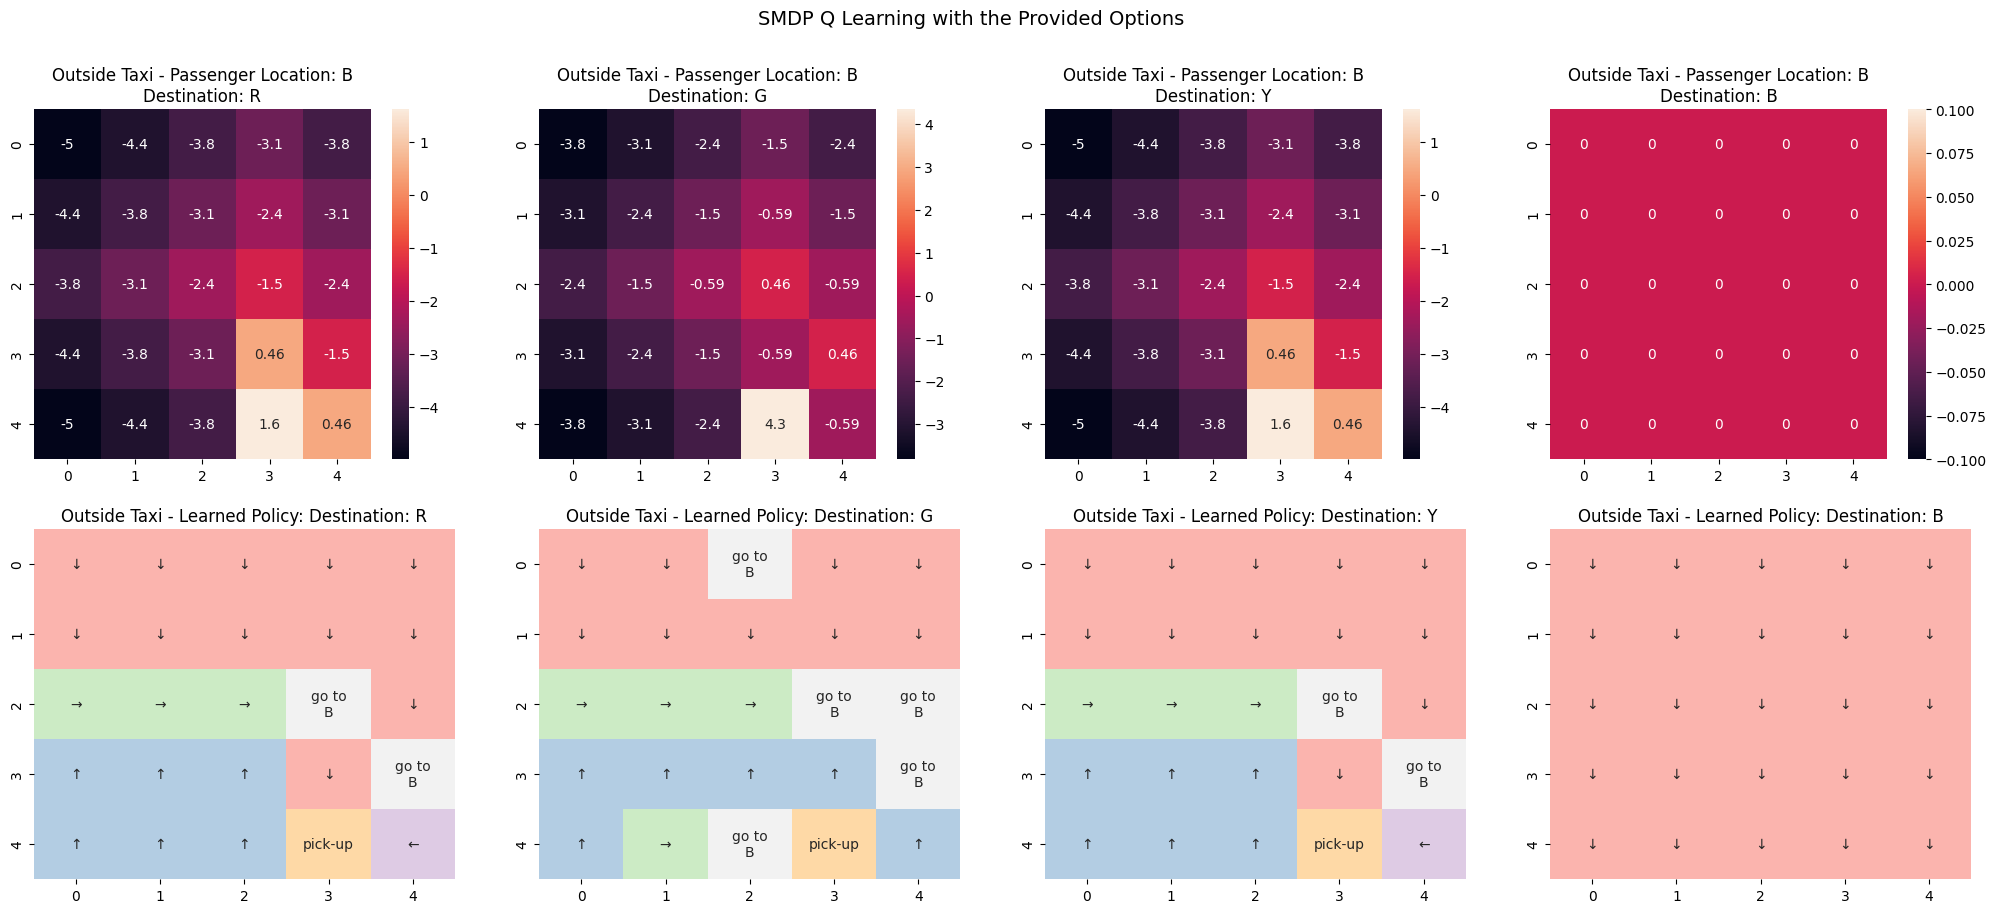

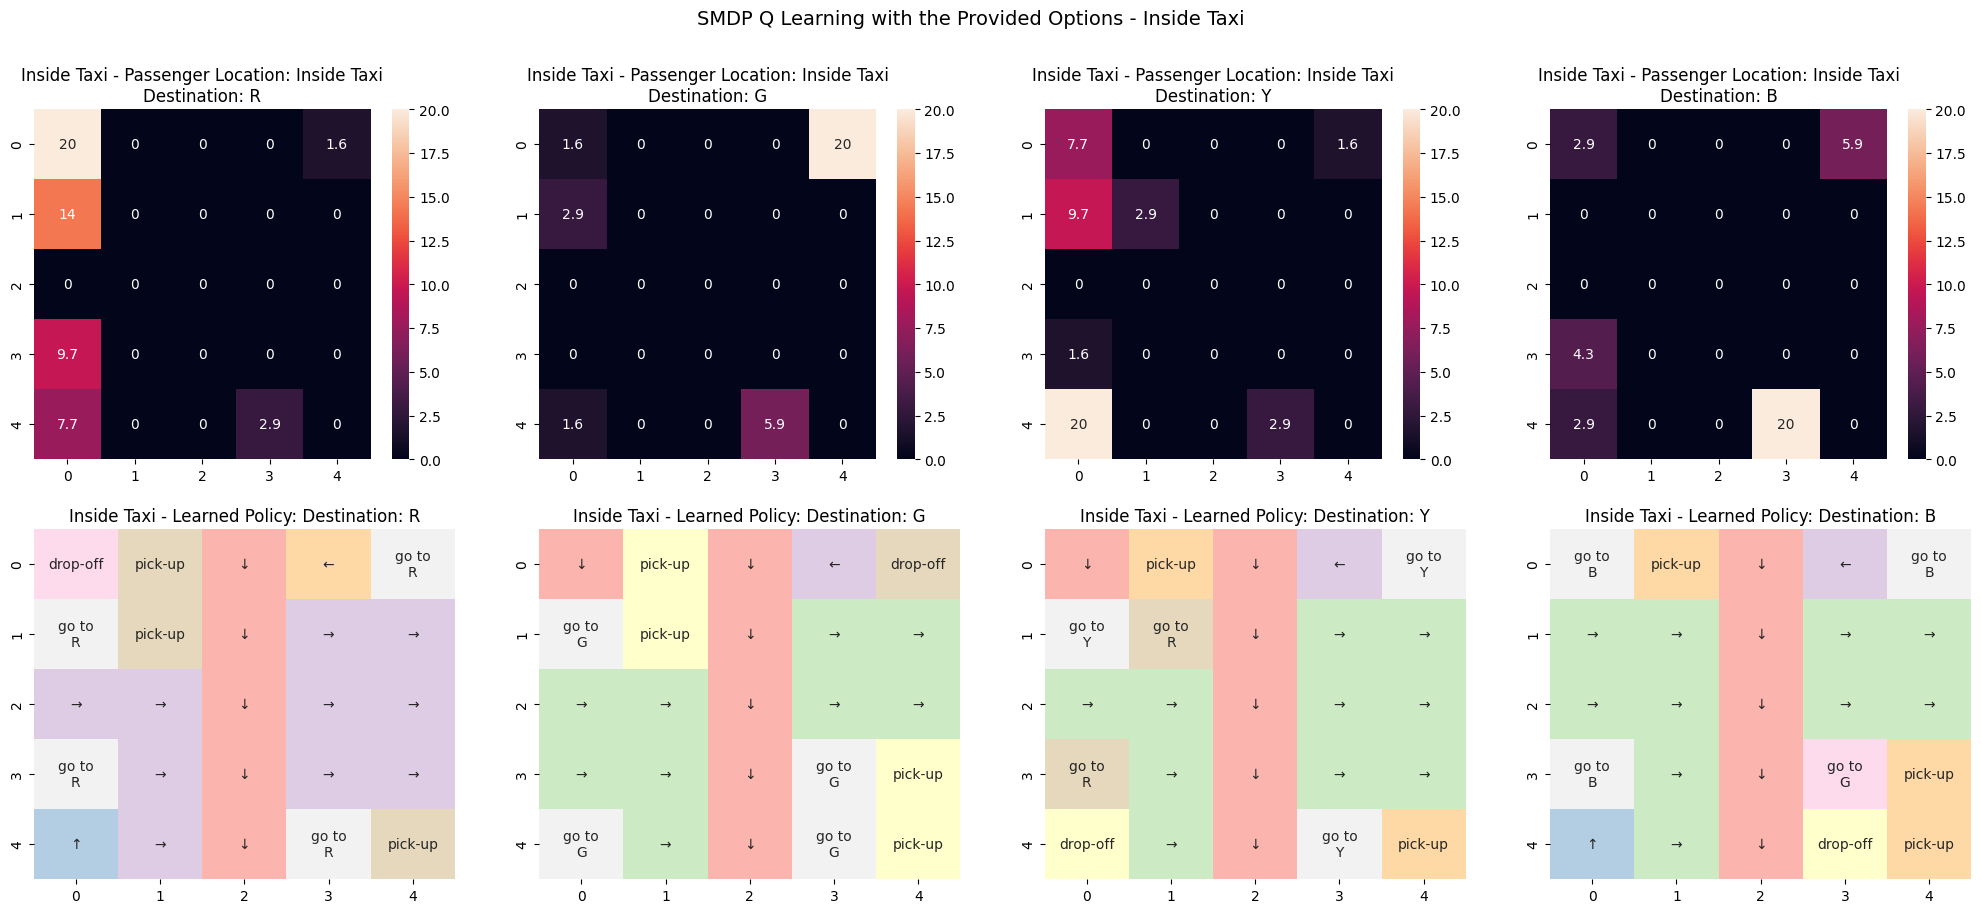

In [20]:
location = [0, 1, 2, 3]
subtitle = 'SMDP Q Learning with the Provided Options'
actions = {0: '↓', 1: '↑', 2: '→', 3: '←',4: 'pick-up', 5: 'drop-off', 6: 'go to\nR', 7: 'go to\nG', 8: 'go to\nY', 9: 'go to\nB'}
pass_loc = {0: 'R', 1: 'G', 2: 'Y', 3: 'B'}
for i in range(4):
    vis_Q_smdp_intra(i,subtitle , env, Q_smdp, actions, pass_loc)

### Ploting the Curvers for best hyperparameters for Intra Q Learning of primitive policies 

In [21]:
# Run the Intra Q-learning algorithm with the best hyperparameters
Q_intra, rewards_intra = Q_learning(env, num_episodes, best_alpha_intra, gamma, best_epsilon_intra, 'provided_option', 'intra')

100%|██████████| 10000/10000 [00:03<00:00, 2711.59it/s]


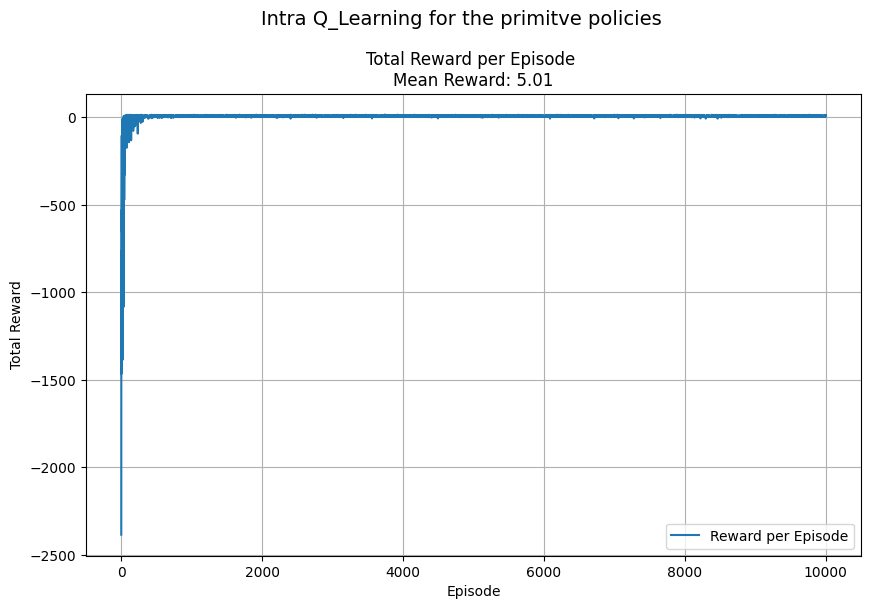

In [22]:
# Reward vs Episodes for Intra Q-learning
reward_vs_episodes(rewards_intra, 'Intra Q_Learning for the primitve policies', num_episodes)

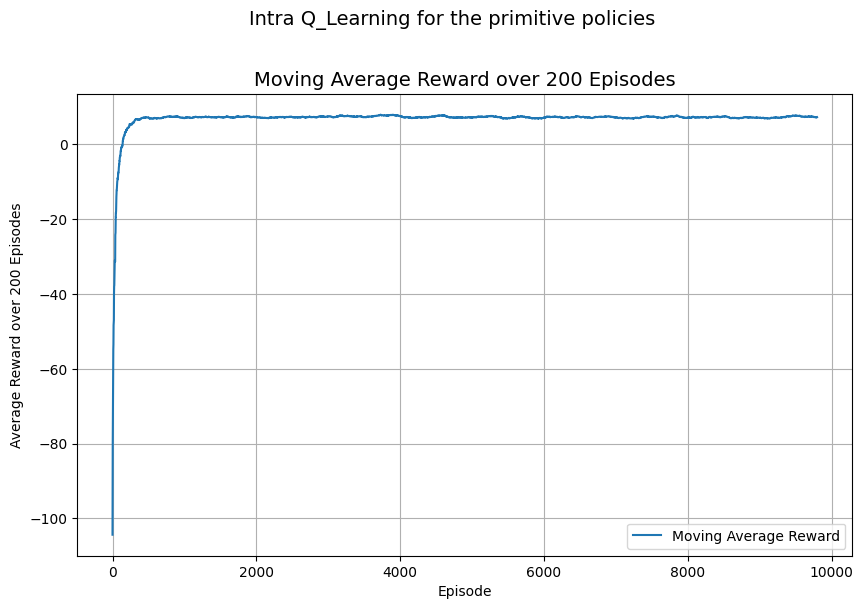

In [23]:
# moving average of rewards over a window of 200 episodes
average_reward(rewards_intra, 'Intra Q_Learning for the primitive policies', num_episodes)

### Plot for Q Values of Intra Q Learning for primitive policies

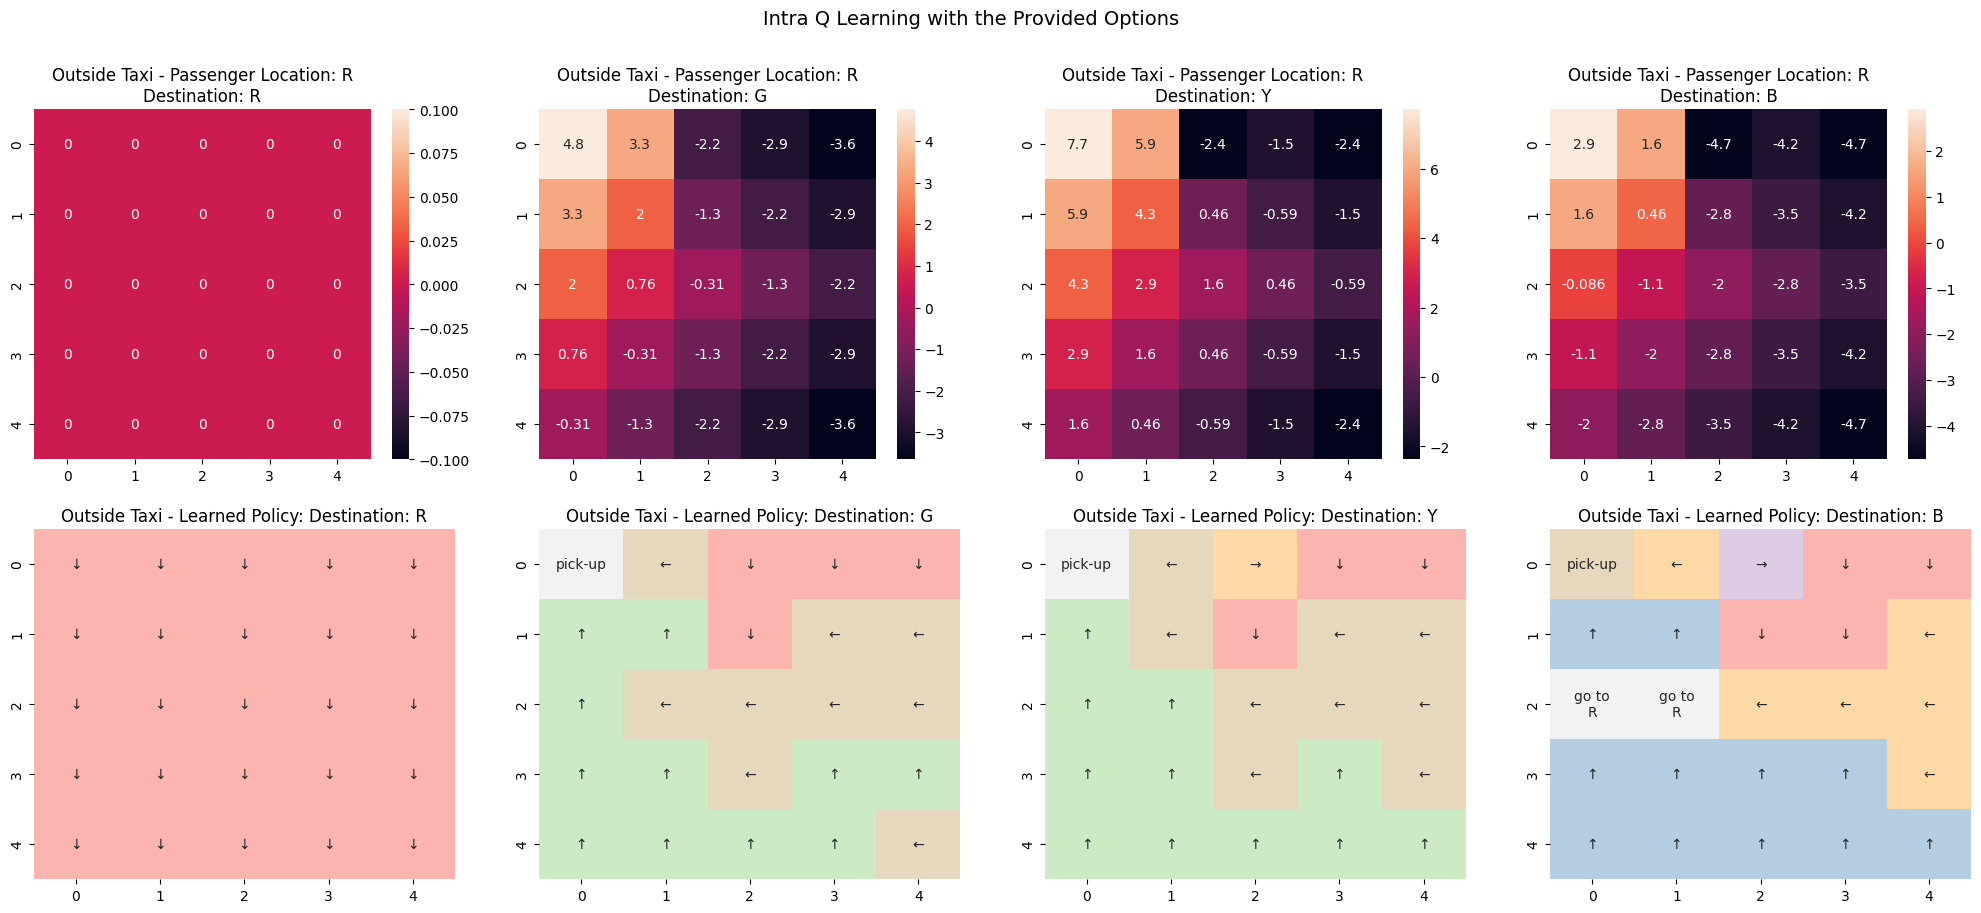

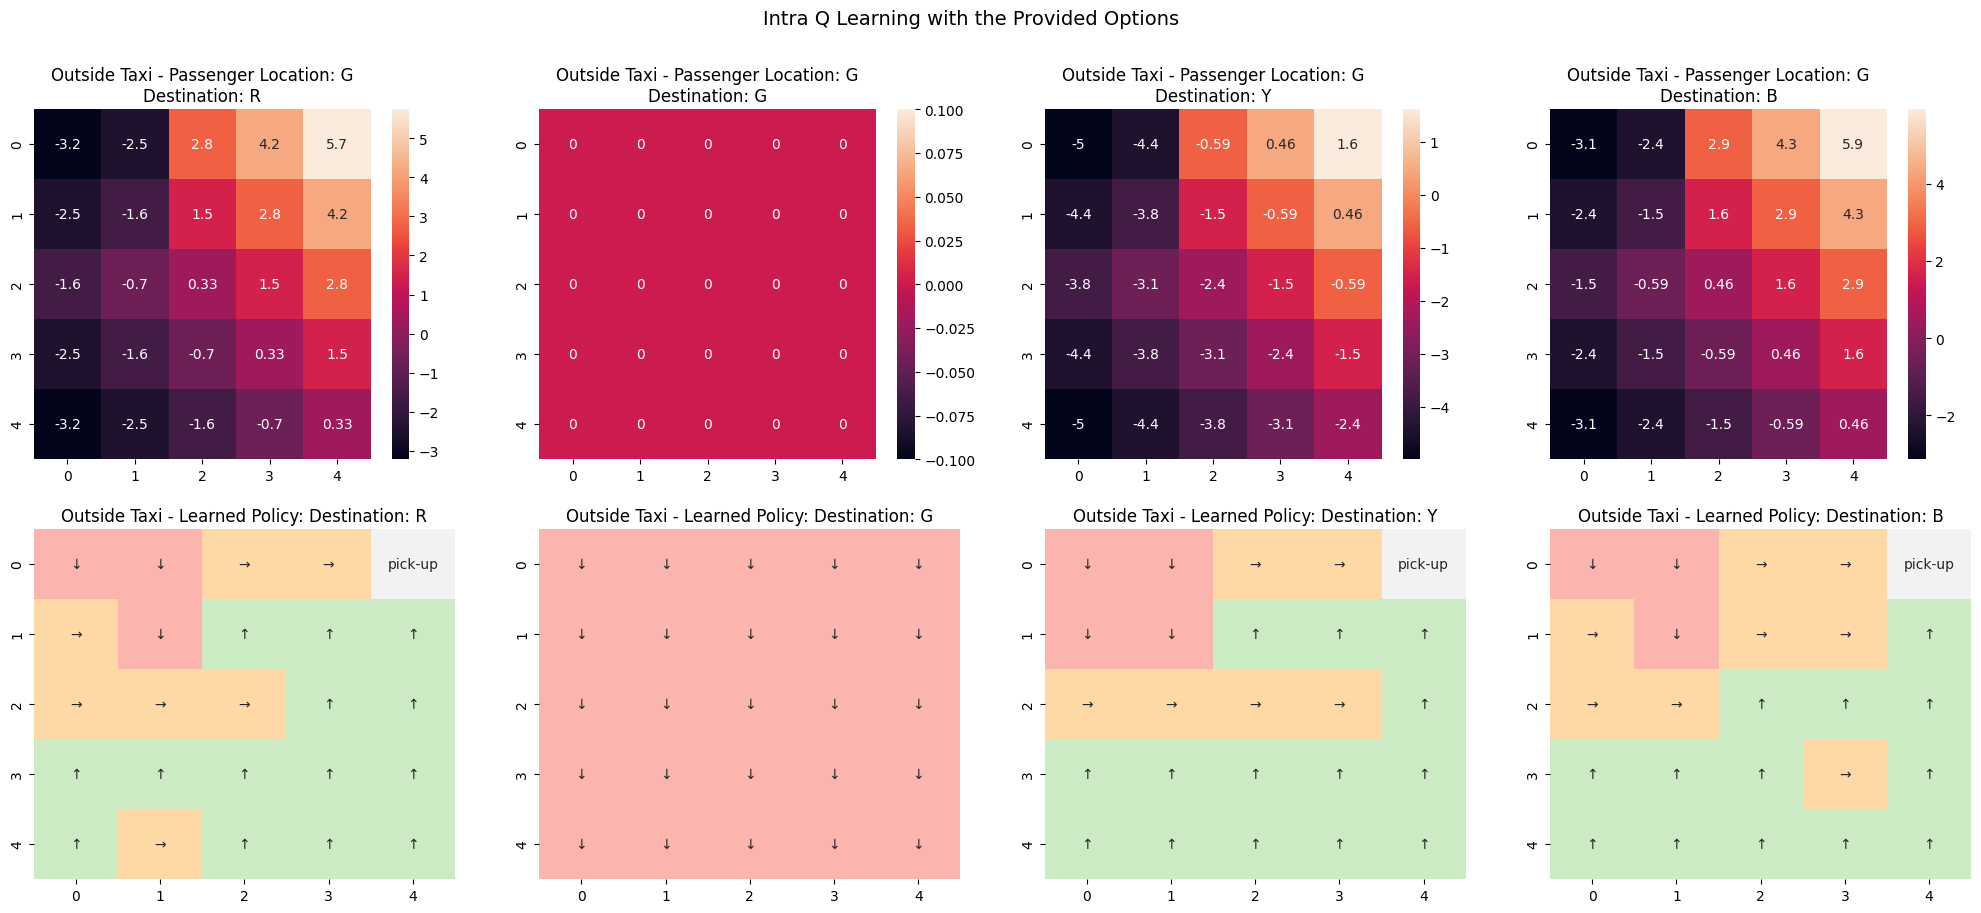

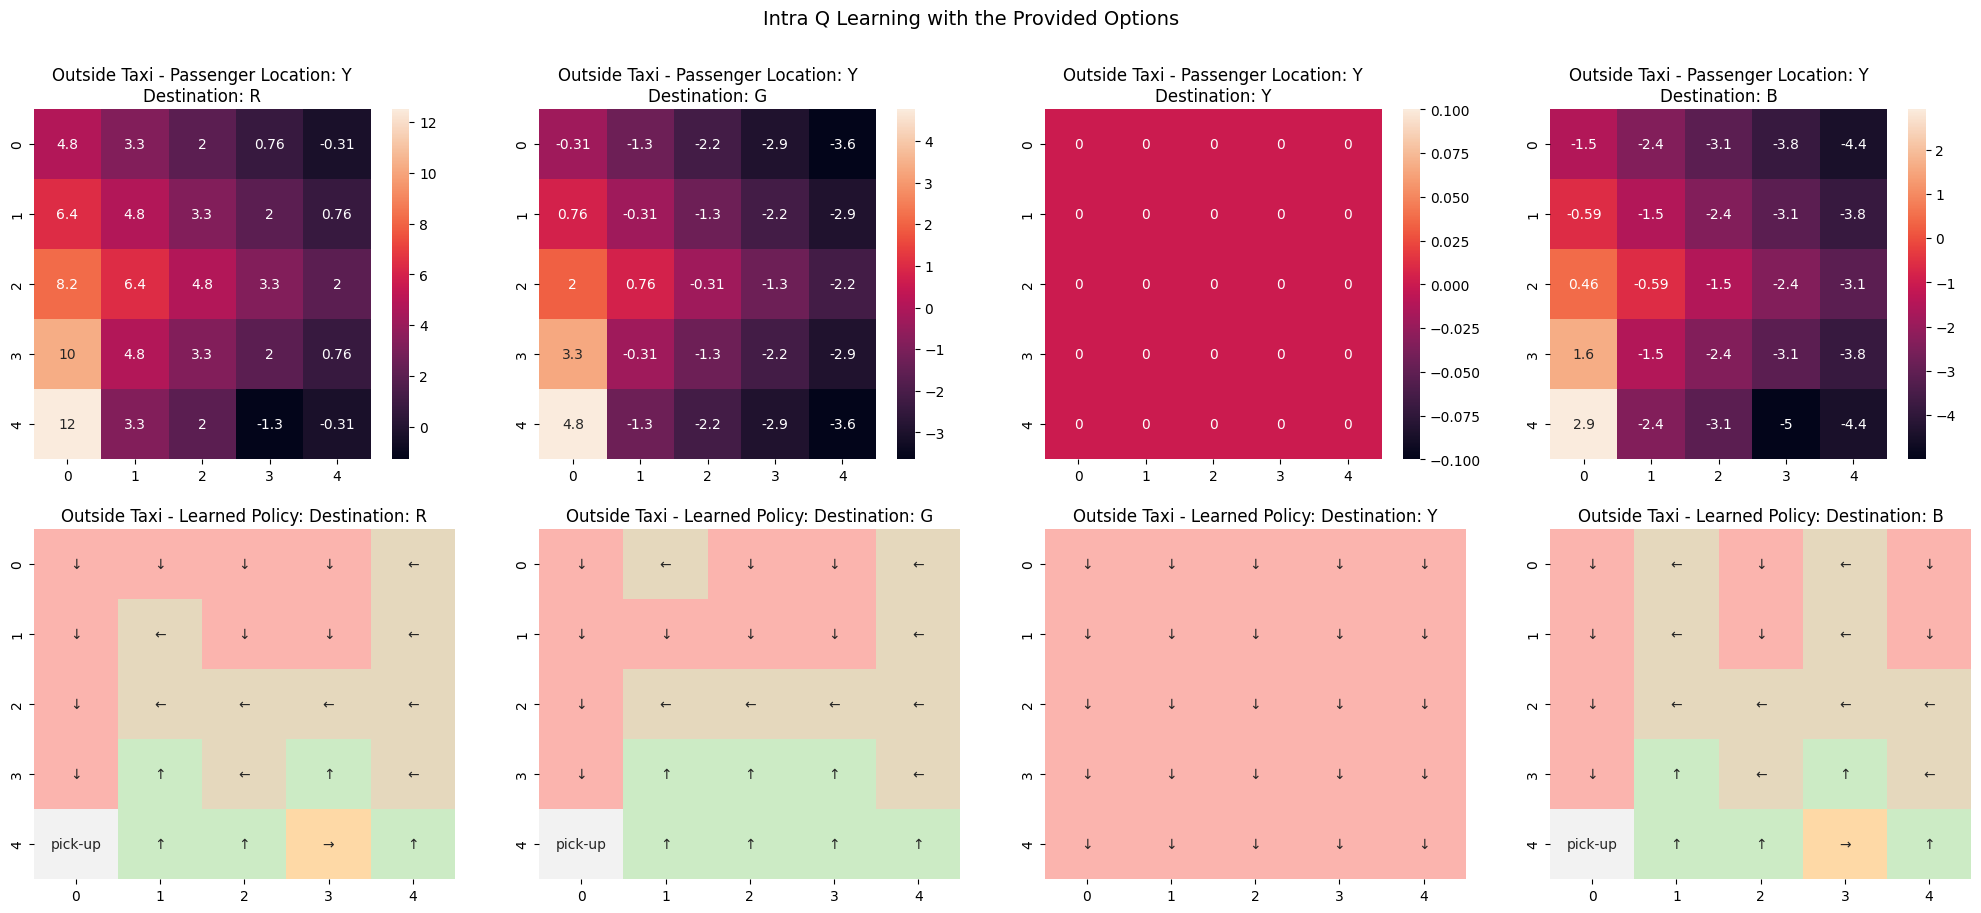

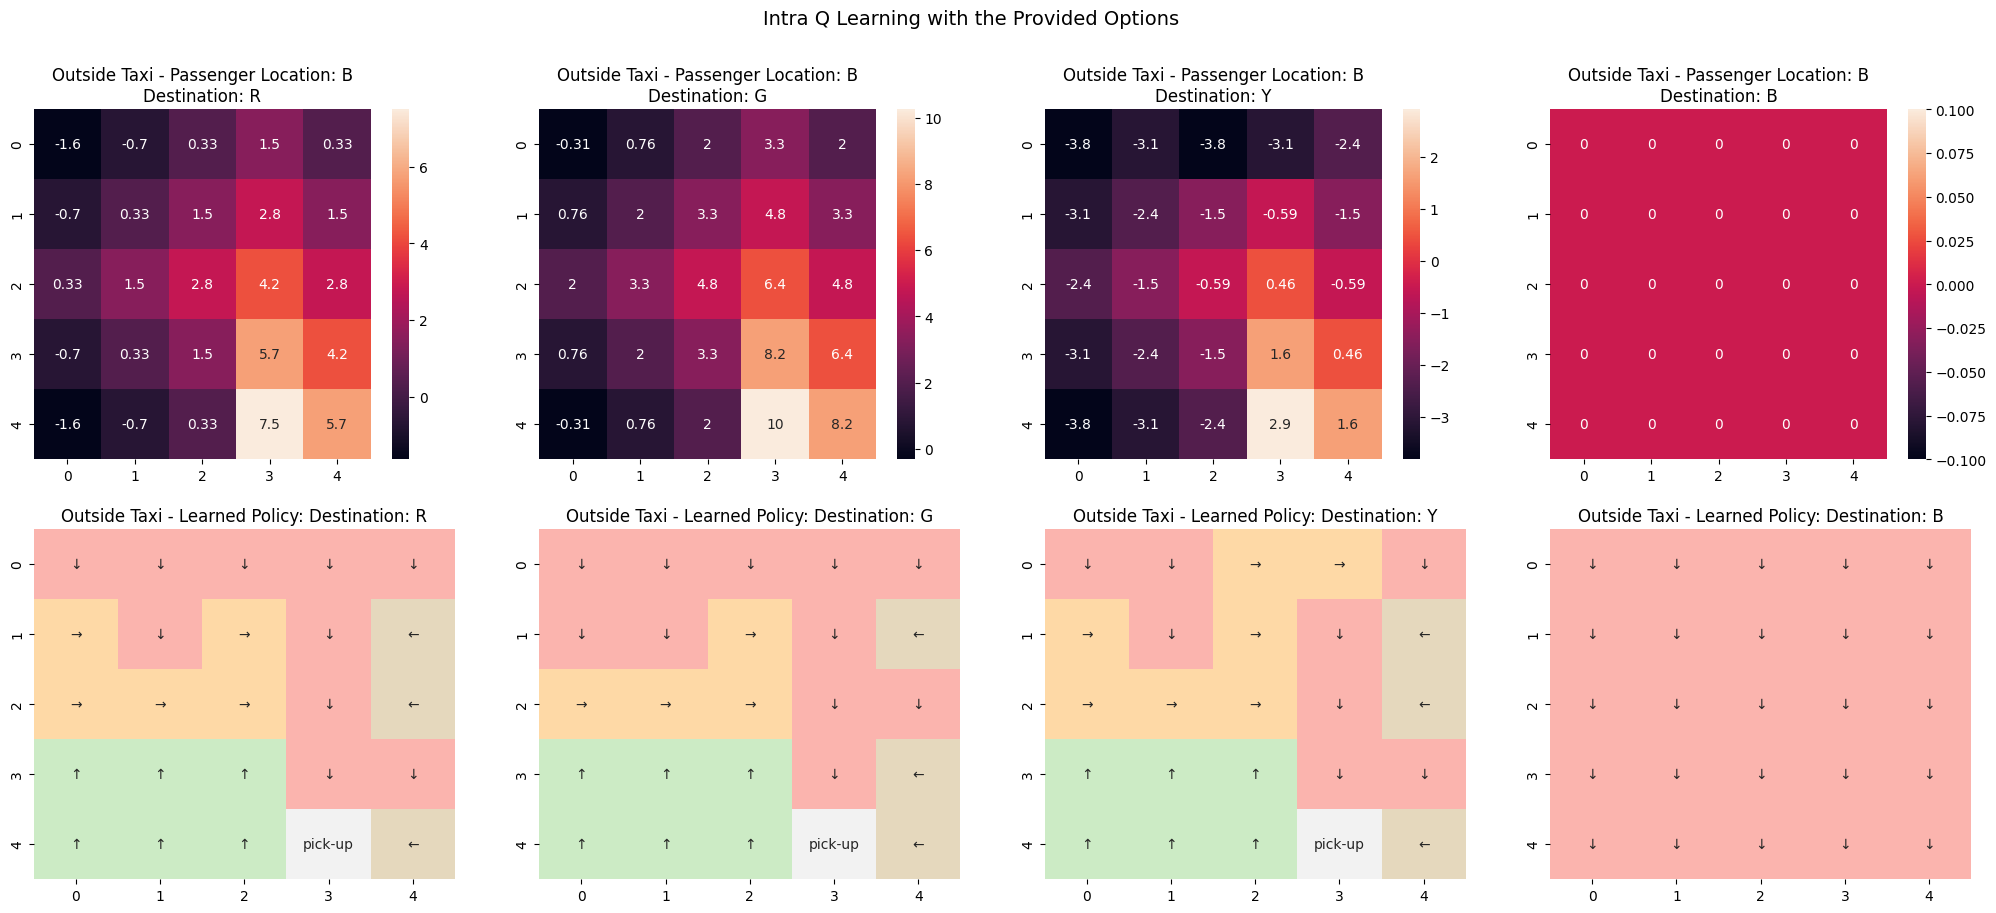

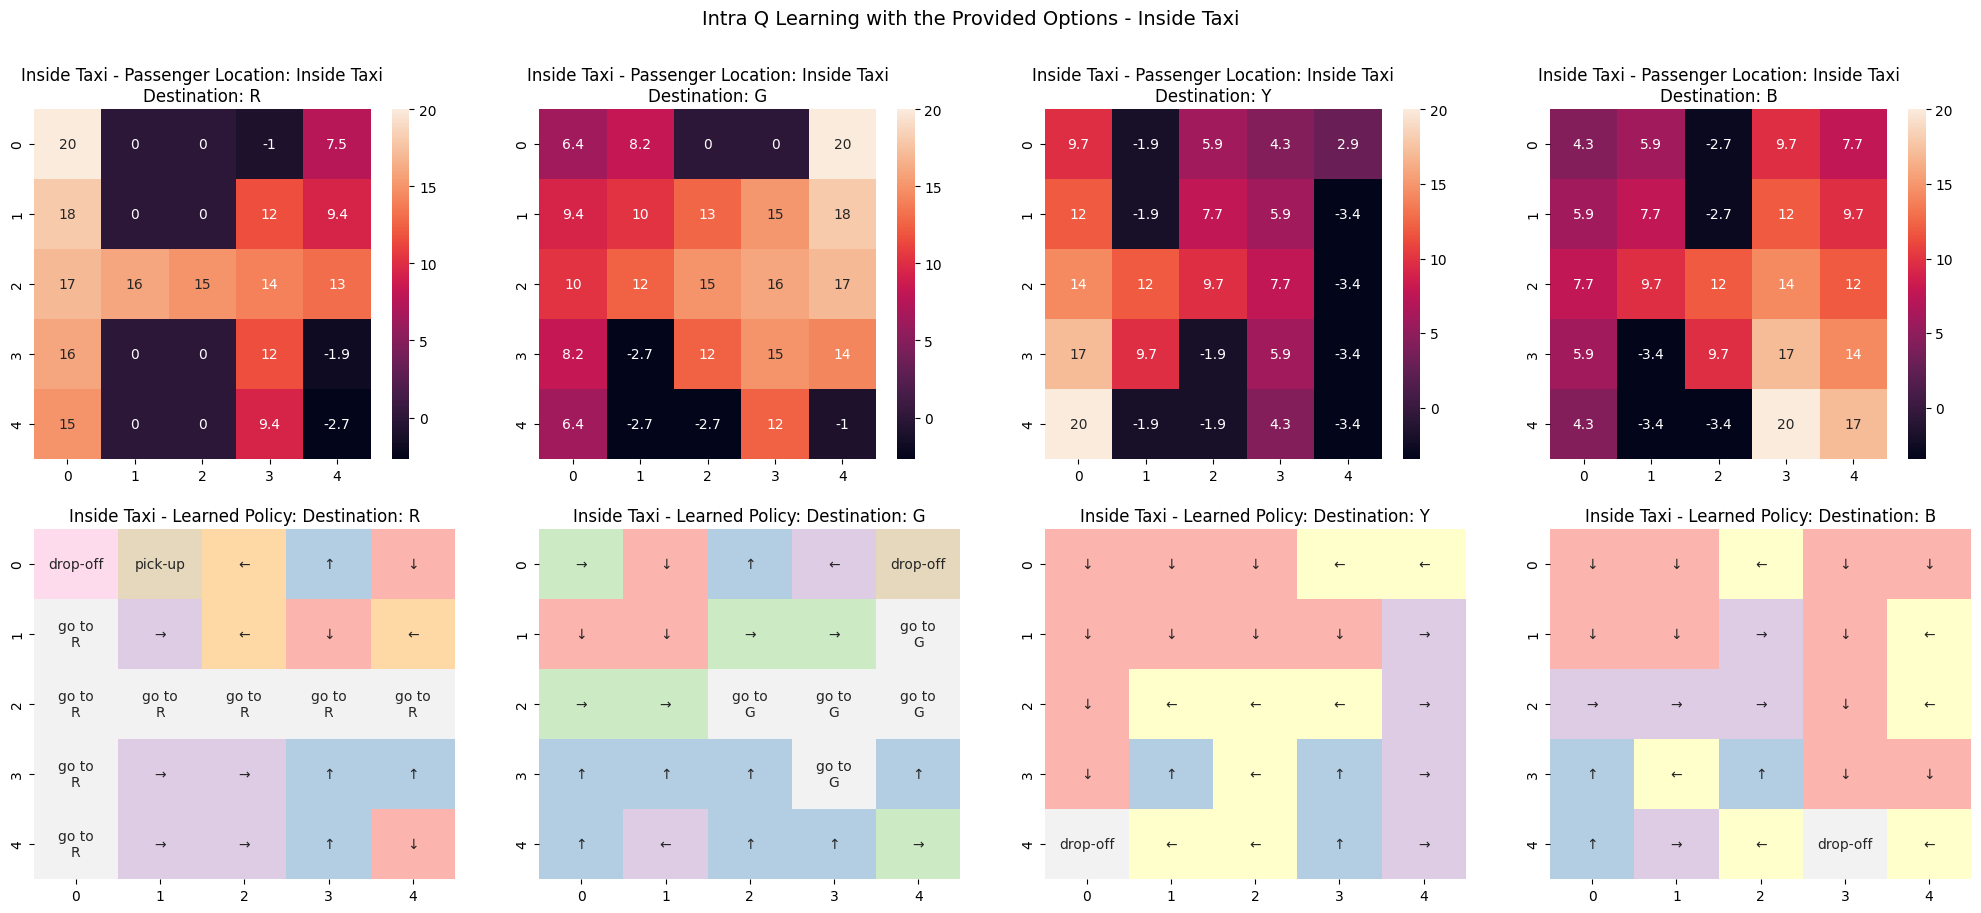

In [24]:
location = [0, 1, 2, 3]
subtitle = 'Intra Q Learning with the Provided Options'
actions = {0: '↓', 1: '↑', 2: '→', 3: '←',4: 'pick-up', 5: 'drop-off', 6: 'go to\nR', 7: 'go to\nG', 8: 'go to\nY', 9: 'go to\nB'}
pass_loc = {0: 'R', 1: 'G', 2: 'Y', 3: 'B'}
for i in range(4):
    vis_Q_smdp_intra(i,subtitle , env, Q_intra, actions, pass_loc)

## Comparision of Average Rewards between SMDP Q Learning and Intra Q Learning on primitive polices

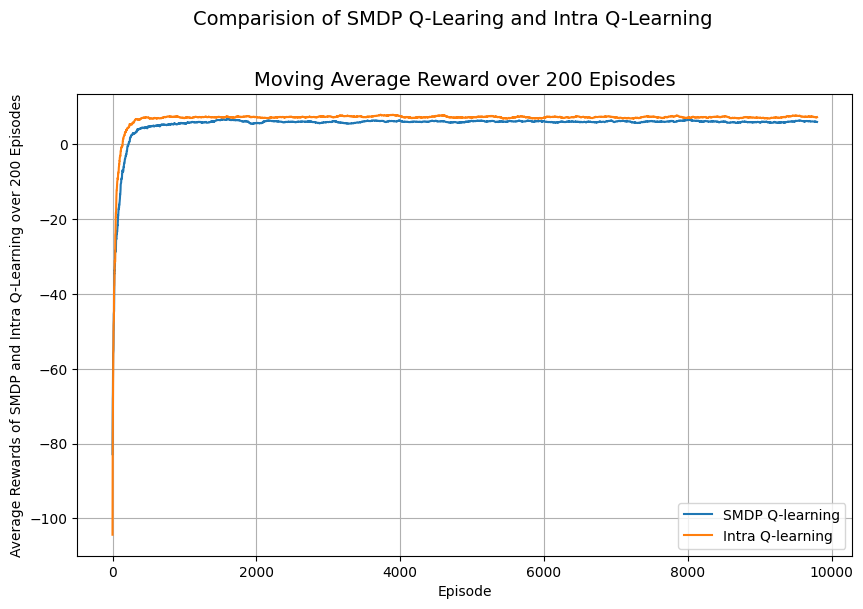

In [25]:
# Comparision of SMDP Q-learning and Intra Q-learning
average_rewards_comp(rewards_smdp, rewards_intra, num_episodes)

## Question 2: Description of the policies learnt and Reasoning behind why the respective algorithm learns the policy.

The following Q-value visualizations and the reward curves depict the learned policies for problems with the taxi domain in the SMDP Q-Learning and the intra-option Q-Learning algorithms.

#### **Description of the policies:**

- **Navigation:** From the Q-Value heatmap, the policy learned by both algorithms is to take an efficient path for the taxi to traverse towards the pickup and dropoff locations. High Q-values (indicated by warm color) suggest that these are preferred actions in the state.

- **Action selection:** There exist learned policies that heavily favor actions that result in a successful pickup and dropoff of a passenger. It can also be observed from the Q-value plots—those actions situated in the states with higher values.

- **State-dependent behavior:** Policies adapt to the current state, including the position of the taxi, the respective position of the passenger, and the destination. This is observable in the varying Q-value patterns with the different locations of the passenger and the destination.

- **Avoidance of illegal actions:** The algorithms naturally learned to avoid such, for instance, it will not try to deliver or pick up at the wrong place, as seen from the very low Q-values learned for any such cases.

#### **Intuition behind Policy Learning:**

- **SMDP Q Learning:**

    - The algorithm teaches by composing a special case of the Bellman Equation.
    - It does this by updating Q-values based on received rewards and transition probabilities that result in the next states.
    - The policy learned follows by choosing actions available at each state, which will maximize these Q-values.
    - The algorithm asymptotically learns an optimal policy after many interactions, balancing exploration and exploitation using an epsilon-greedy strategy.

- **Intra-option Q-Learning**

    - This model extends the basic SMDP Q-Learning method by allowing multiple options to be learned about in a parallel process.
    - The Q-value of the actions taken in the present state are updated as well as those of the actions chosen for the next states.
    - The parallel process results in improving the convergence speed. Impliedly, the learning time is minimized since several possibilities get dealt with simultaneously.
    - This results in a policy which can, in turn, benefit from the richer learning process, and is therefore likely to be stronger; strategy will be learnt more quickly.

## Qestion 3: New Set of Options for SMDP and Intra Q Learning

### Finding Best Hyperparameters for new options (0,1), (3,1), (0,3) and (3,3)

In [27]:
alpha = [0.001, 0.01,0.1, 1]
gamma = 0.9
epsilon = [0.001,0.01, 0.05, 0.1]
num_episodes = 10000
# environment setup
env = gym.make('Taxi-v3')

# finding the best hyperparameters for SMDP Q-learning
new_best_alpha_smdp, new_best_epsilon_smdp = best_hyperparameters(env, num_episodes, alpha, gamma, epsilon, 'new_option', 'SMDP')
print(f'Best alpha for SMDP Q-learning: {best_alpha_smdp}')
print(f'Best epsilon for SMDP Q-learning: {best_epsilon_smdp}')

# finding the best hyperparameters for Intra Q-learning
new_best_alpha_intra, new_best_epsilon_intra = best_hyperparameters(env, num_episodes, alpha, gamma, epsilon, 'new_option', 'intra')
print(f'Best alpha for Intra Q-learning: {best_alpha_intra}')
print(f'Best epsilon for Intra Q-learning: {best_epsilon_intra}')

100%|██████████| 10000/10000 [00:03<00:00, 3044.43it/s]


Best alpha for SMDP Q-learning: 1
Best epsilon for SMDP Q-learning: 0.001


100%|██████████| 10000/10000 [00:02<00:00, 3814.41it/s]

Best alpha for Intra Q-learning: 1
Best epsilon for Intra Q-learning: 0.001


### Plotting the Curver of SMDP Q Learning for New Policies

In [28]:
new_Q_smdp, new_rewards_smdp = Q_learning(env, num_episodes, new_best_alpha_smdp, gamma, new_best_epsilon_smdp, 'new_option', 'SMDP')

100%|██████████| 10000/10000 [00:02<00:00, 4139.87it/s]


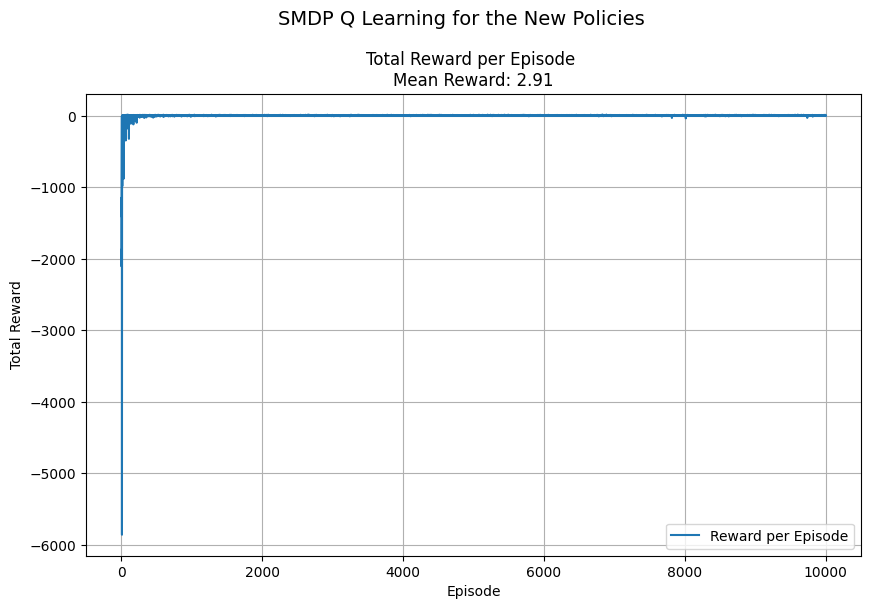

In [29]:
# Reward vs Episodes for SMDP Q-learning
reward_vs_episodes(new_rewards_smdp, 'SMDP Q Learning for the New Policies', num_episodes)

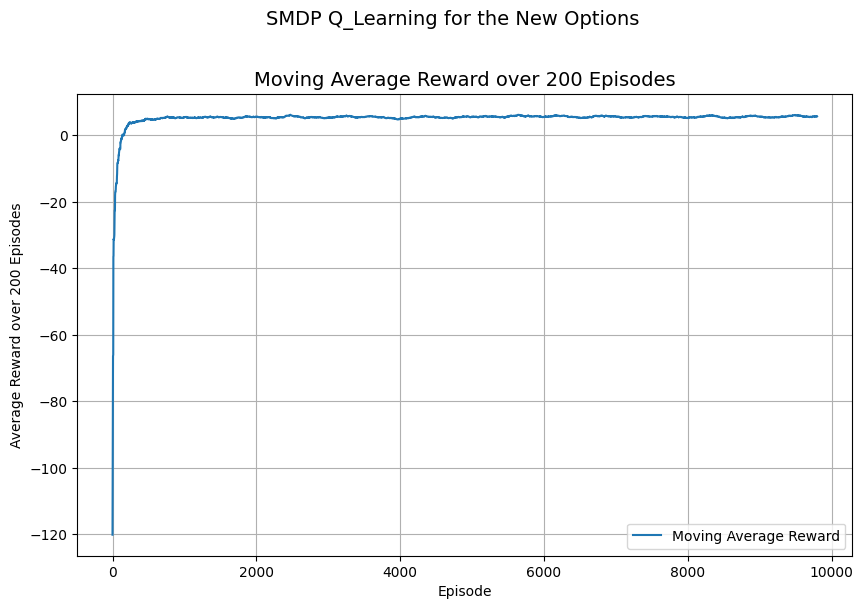

In [30]:
# Moving Average Reward for SMDP Q-learning
average_reward(new_rewards_smdp, 'SMDP Q_Learning for the New Options', num_episodes)

### Q Values Plots for SMDP Q Learning for New Options

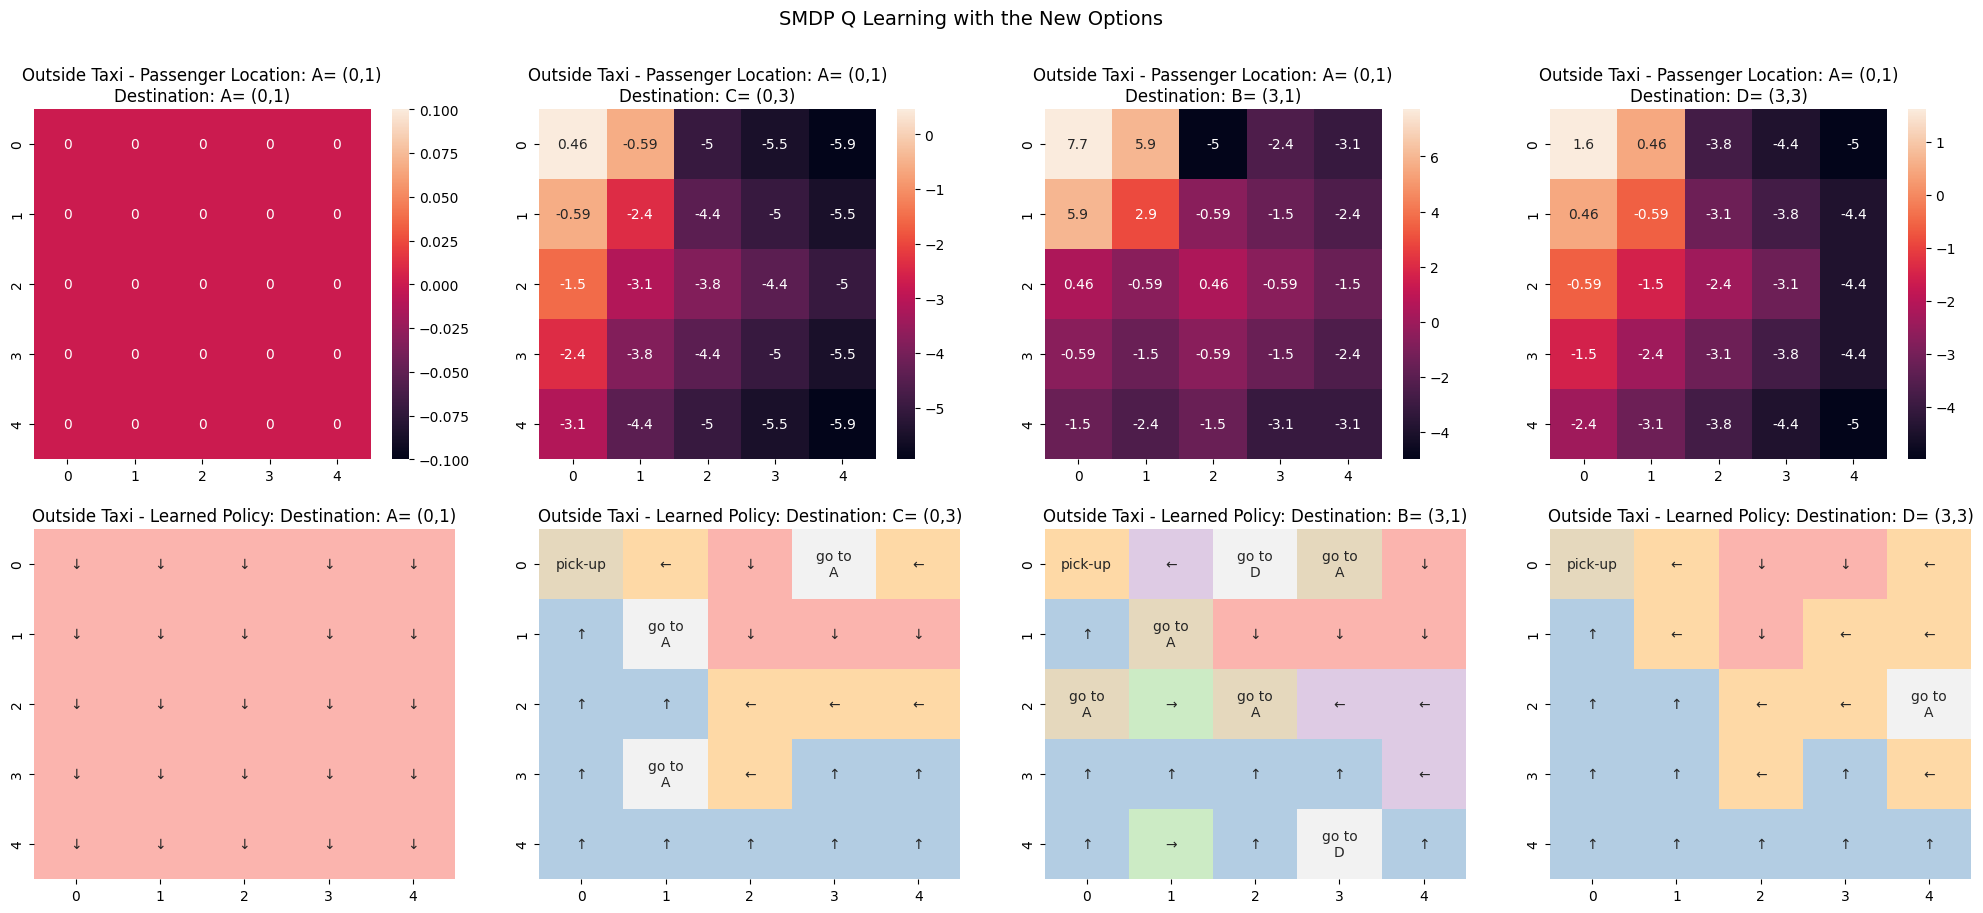

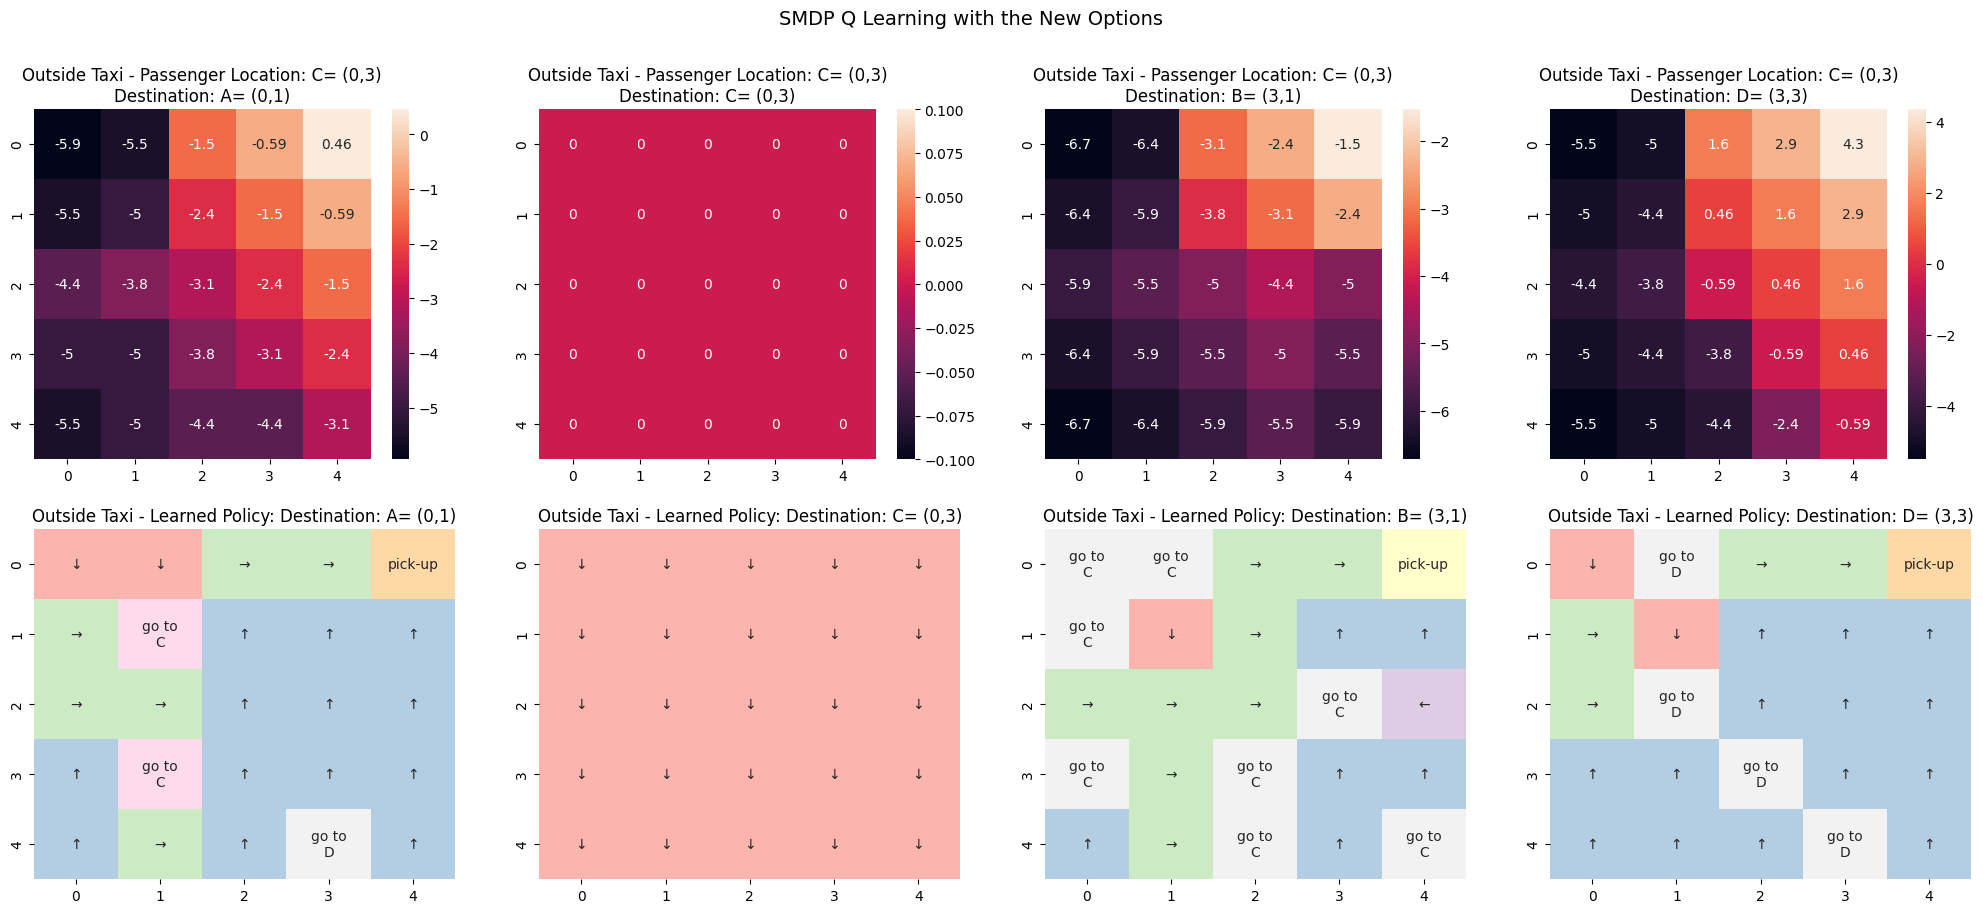

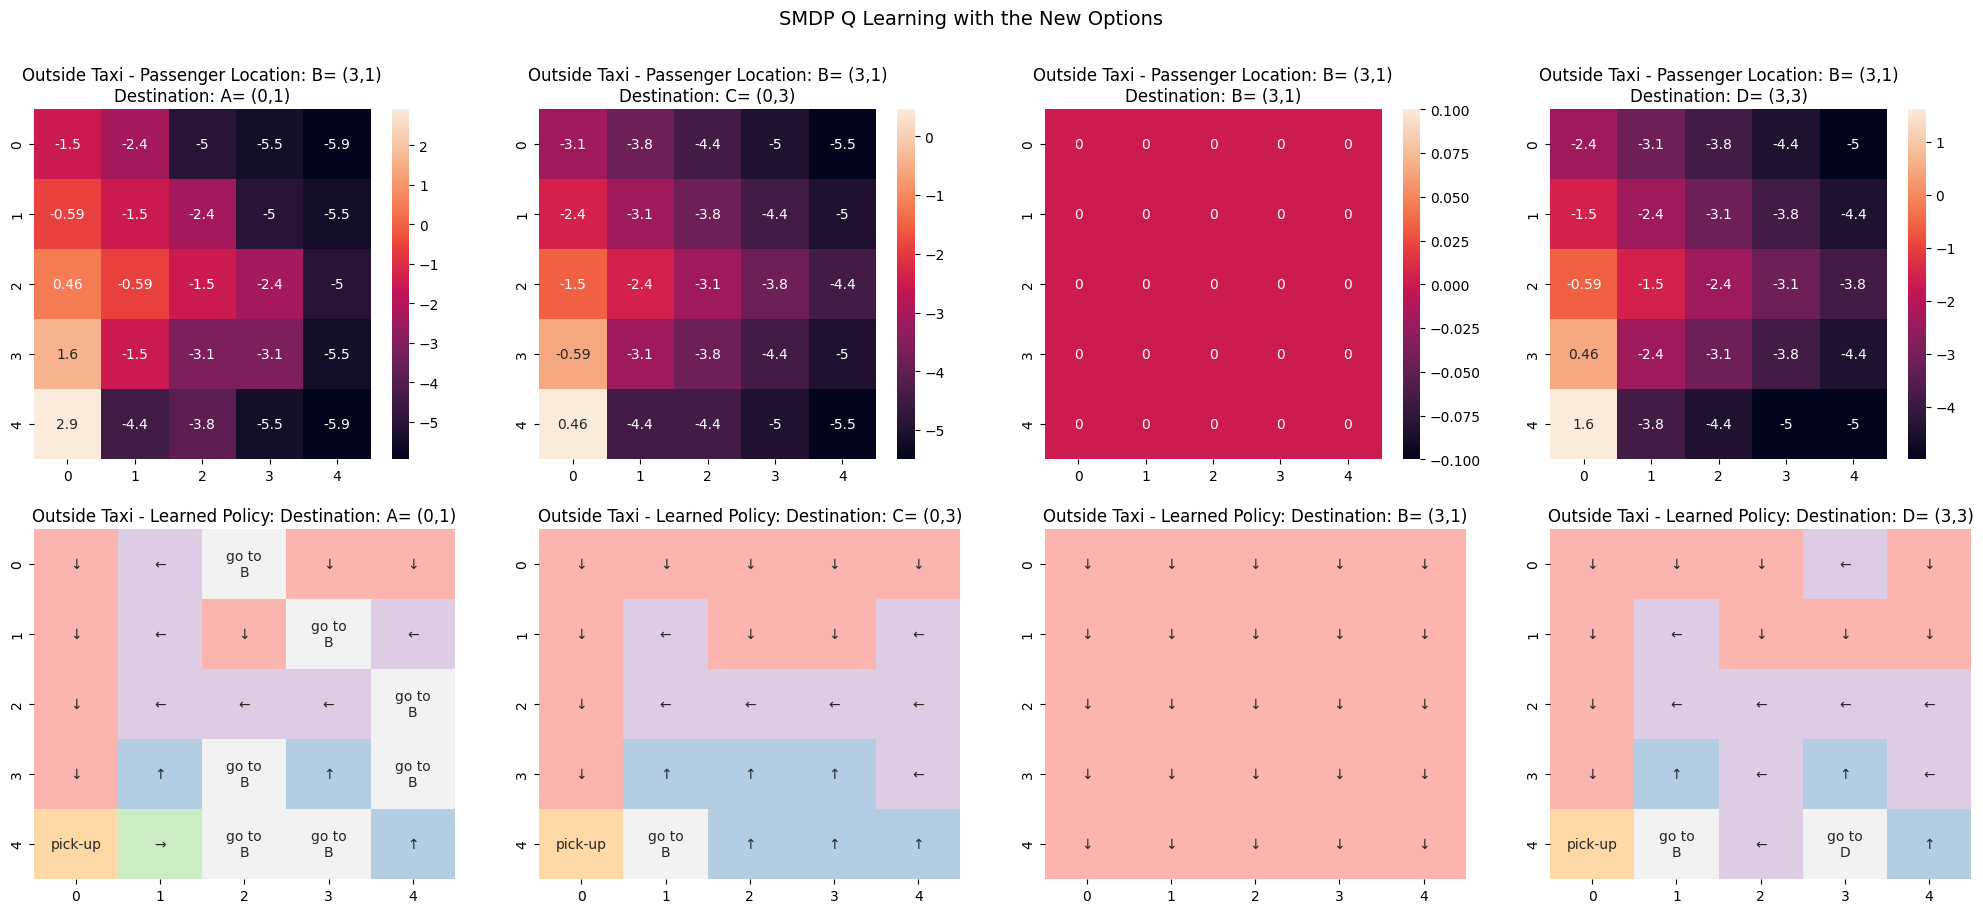

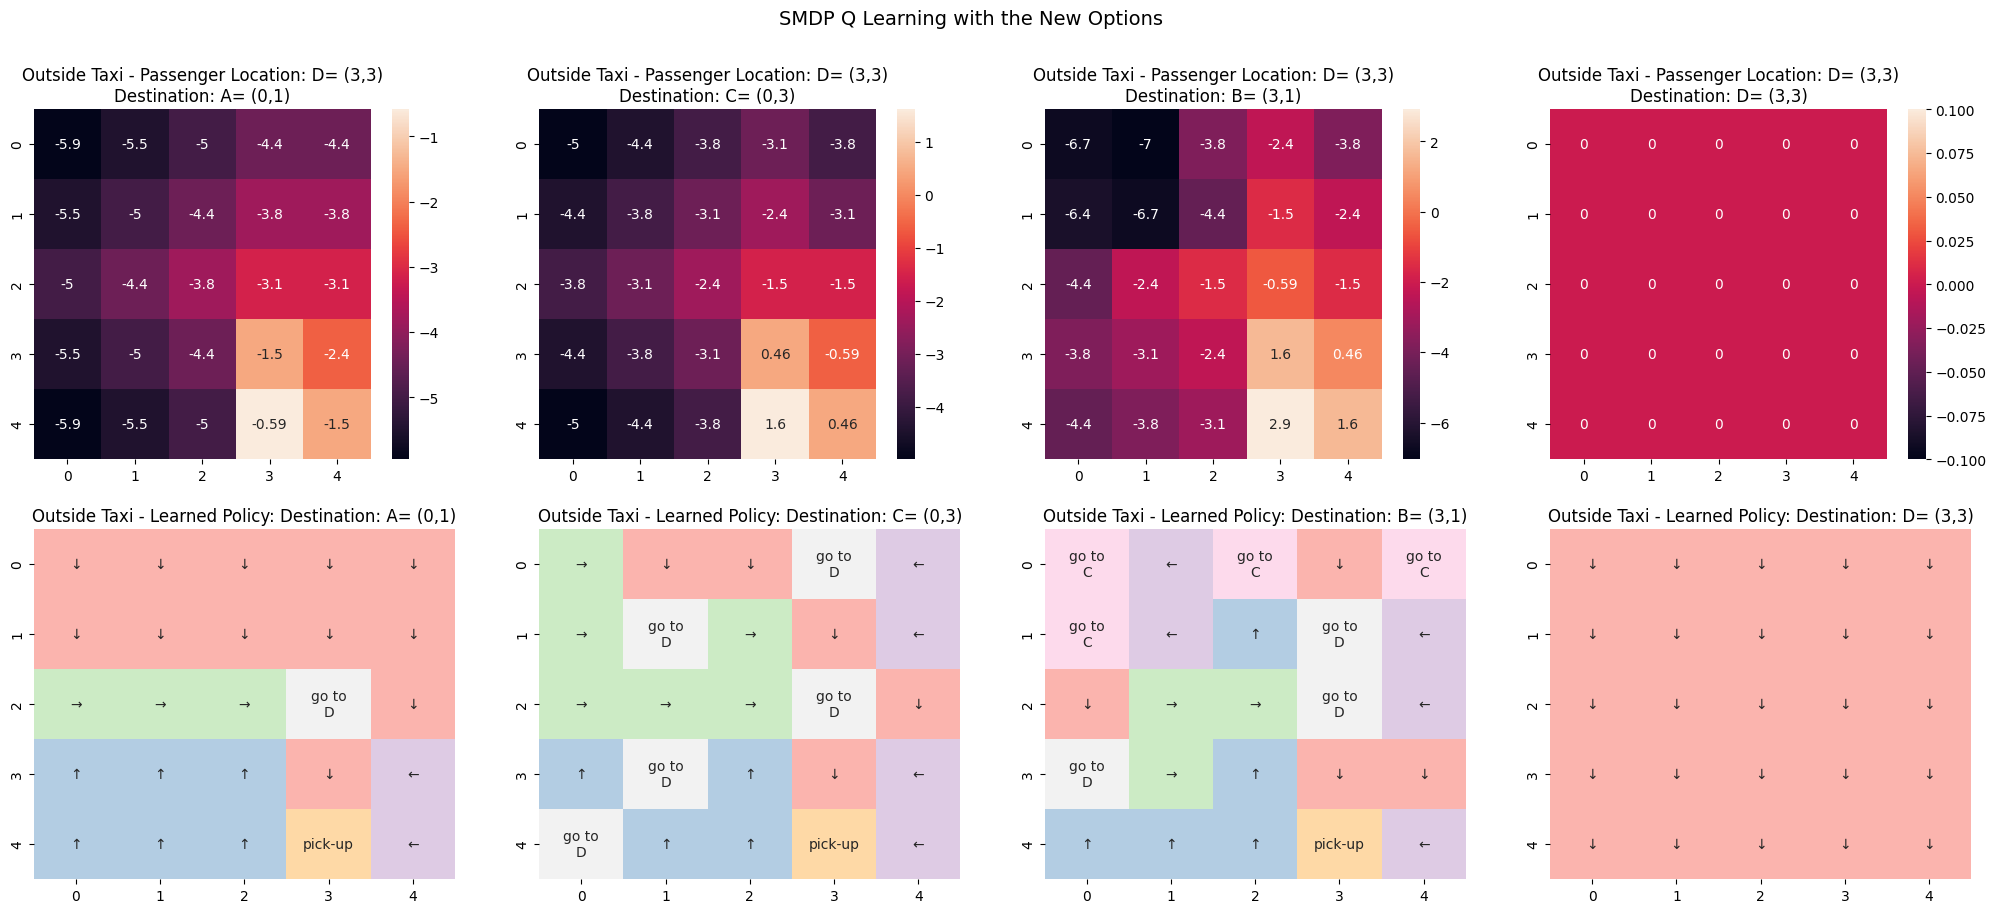

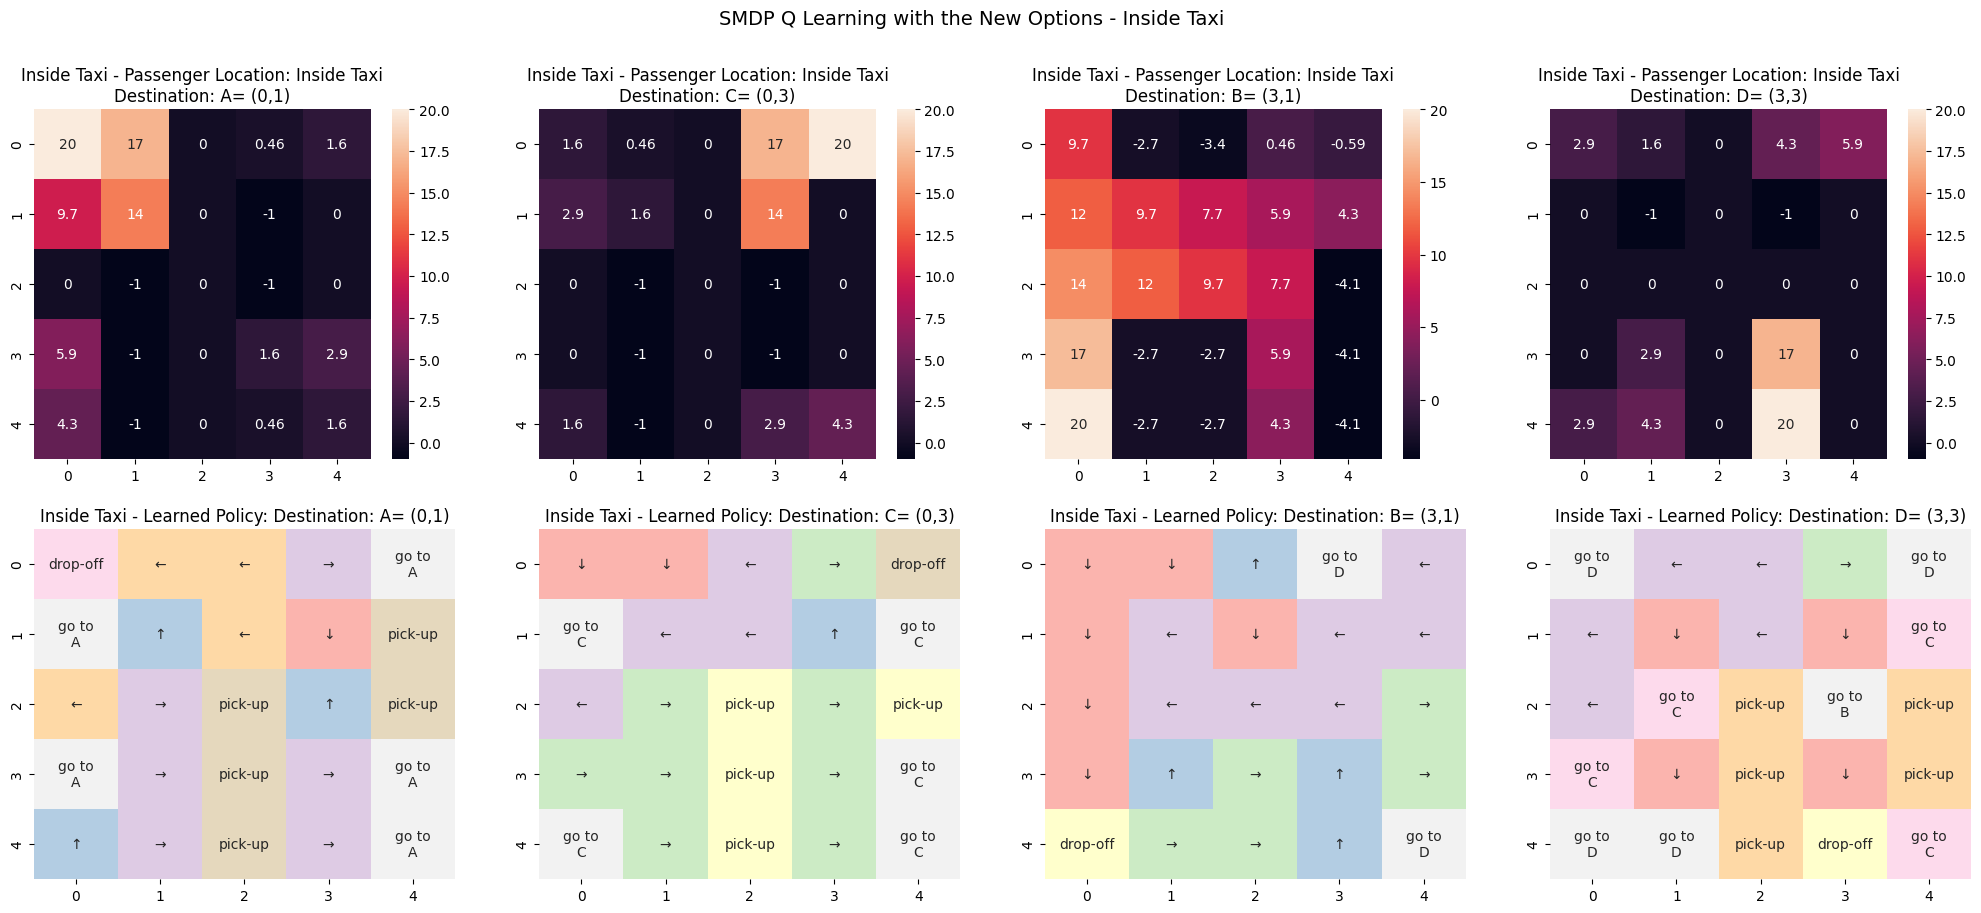

In [31]:
location = [0, 1, 2, 3]
subtitle = 'SMDP Q Learning with the New Options'
actions = {0: '↓', 1: '↑', 2: '→', 3: '←',4: 'pick-up', 5: 'drop-off', 6: 'go to\nA', 7: 'go to\nC', 8: 'go to\nB', 9: 'go to\nD'}
pass_loc = {0: 'A= (0,1)', 1: 'C= (0,3)', 2: 'B= (3,1)', 3: 'D= (3,3)'}
for i in range(4):
    vis_Q_smdp_intra(i,subtitle , env, new_Q_smdp, actions, pass_loc)

### Ploting the Curvers for best hyperparameters for Intra Q Learning of New Options

In [32]:
# Run the Intra Q-learning algorithm with the best hyperparameters
new_Q_intra, new_rewards_intra = Q_learning(env, num_episodes, new_best_alpha_intra, gamma, new_best_epsilon_intra, 'new_option', 'intra')

100%|██████████| 10000/10000 [00:02<00:00, 3914.81it/s]


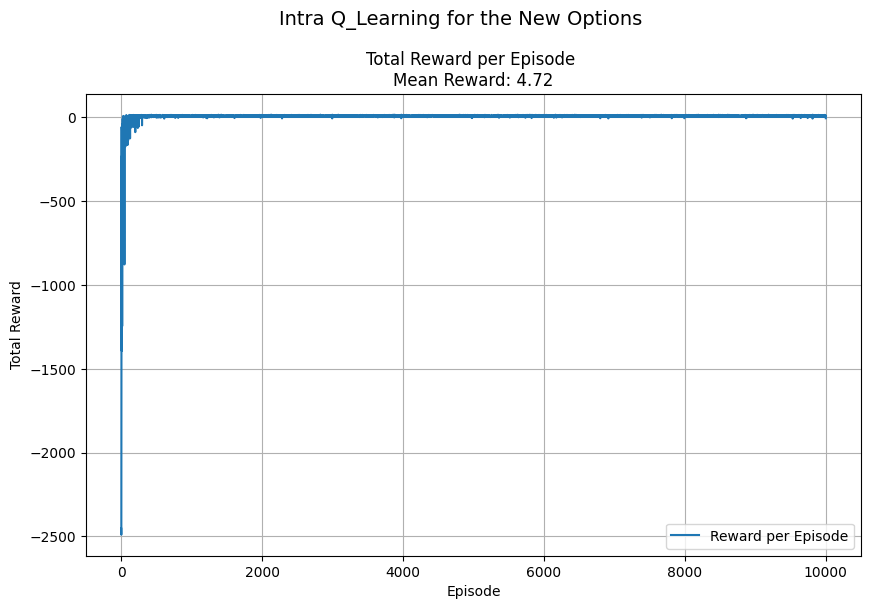

In [33]:
# Reward vs Episodes for Intra Q-learning
reward_vs_episodes(new_rewards_intra, 'Intra Q_Learning for the New Options', num_episodes)

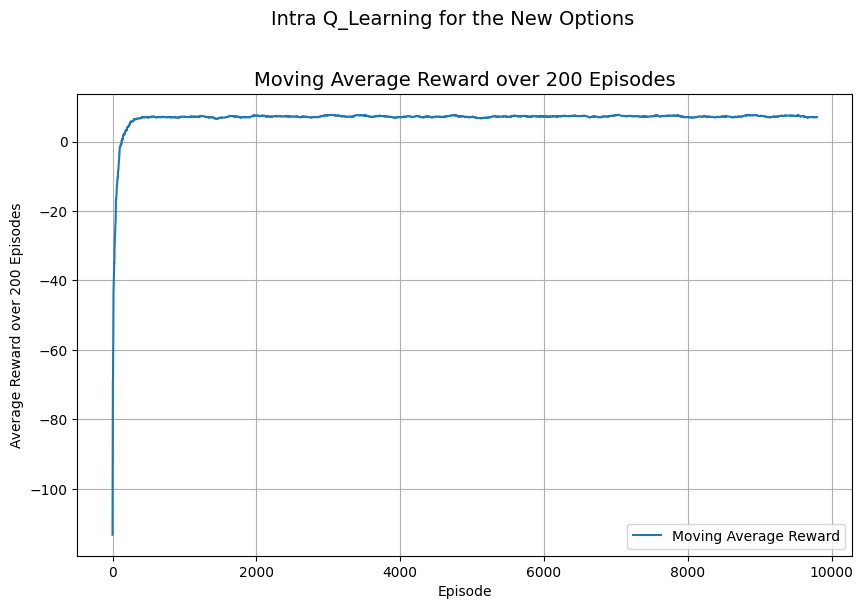

In [34]:
# moving average of rewards over a window of 200 episodes
average_reward(new_rewards_intra, 'Intra Q_Learning for the New Options', num_episodes)

### Plot for Q Values of Intra Q Learning for New Options

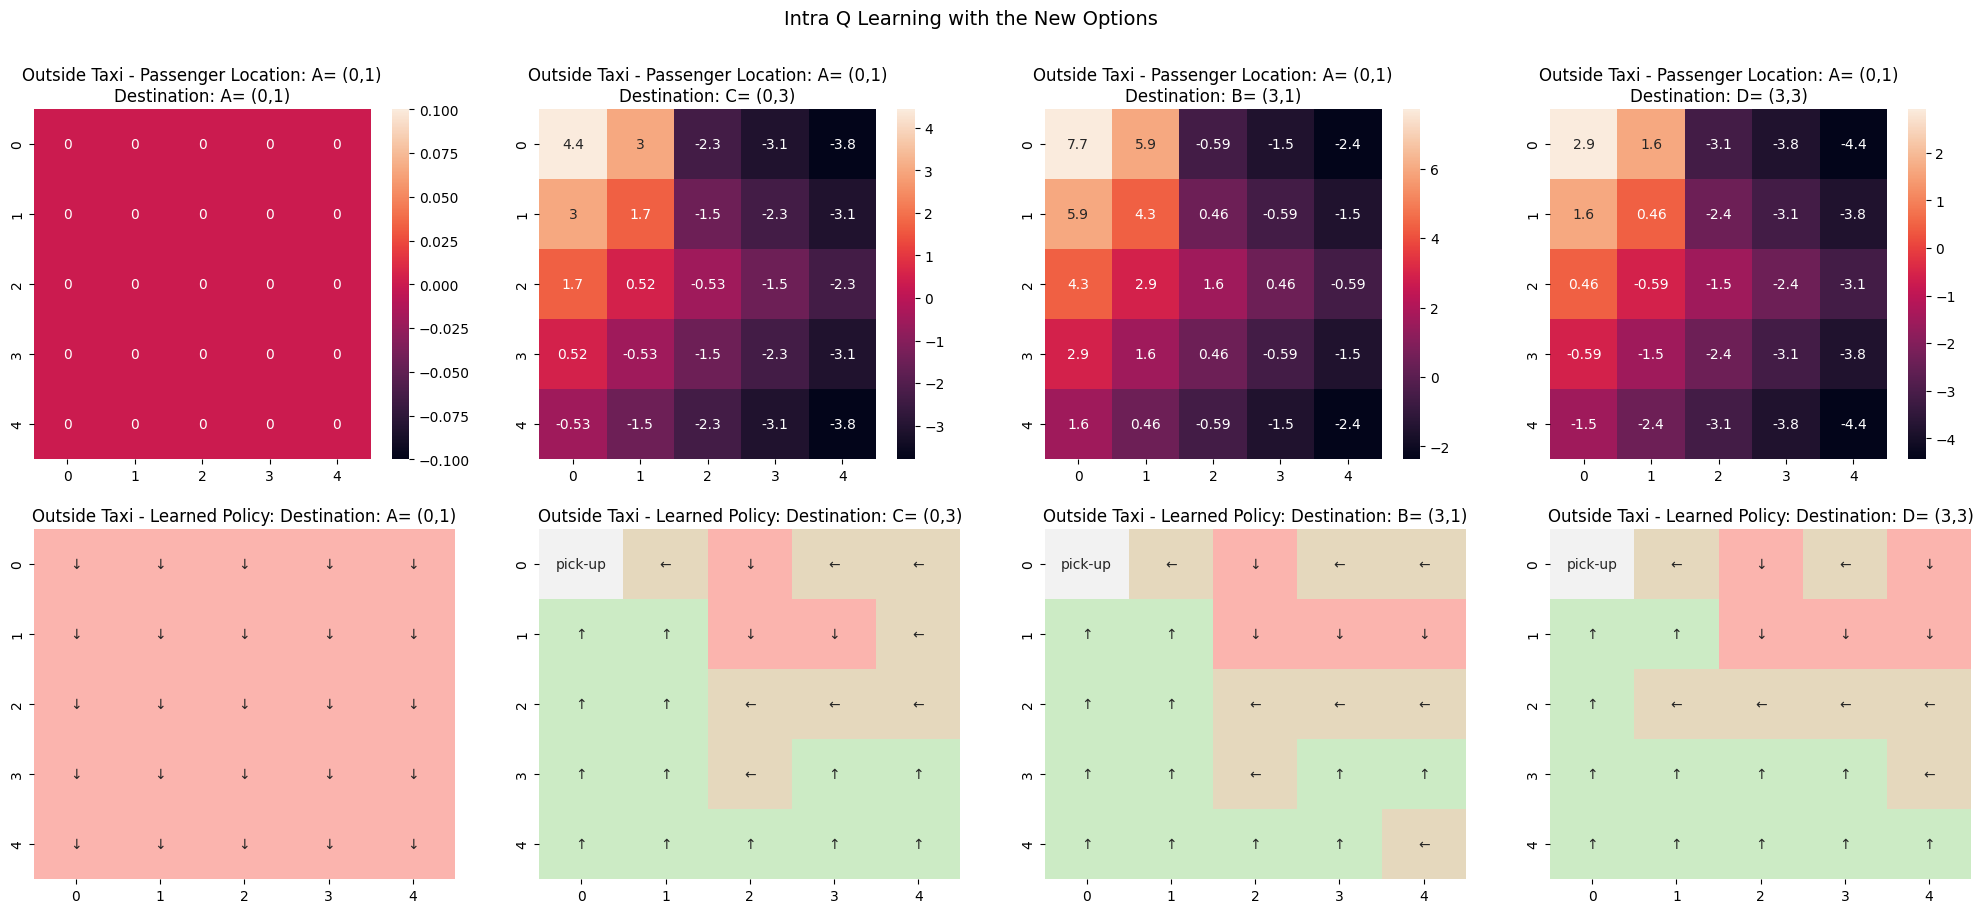

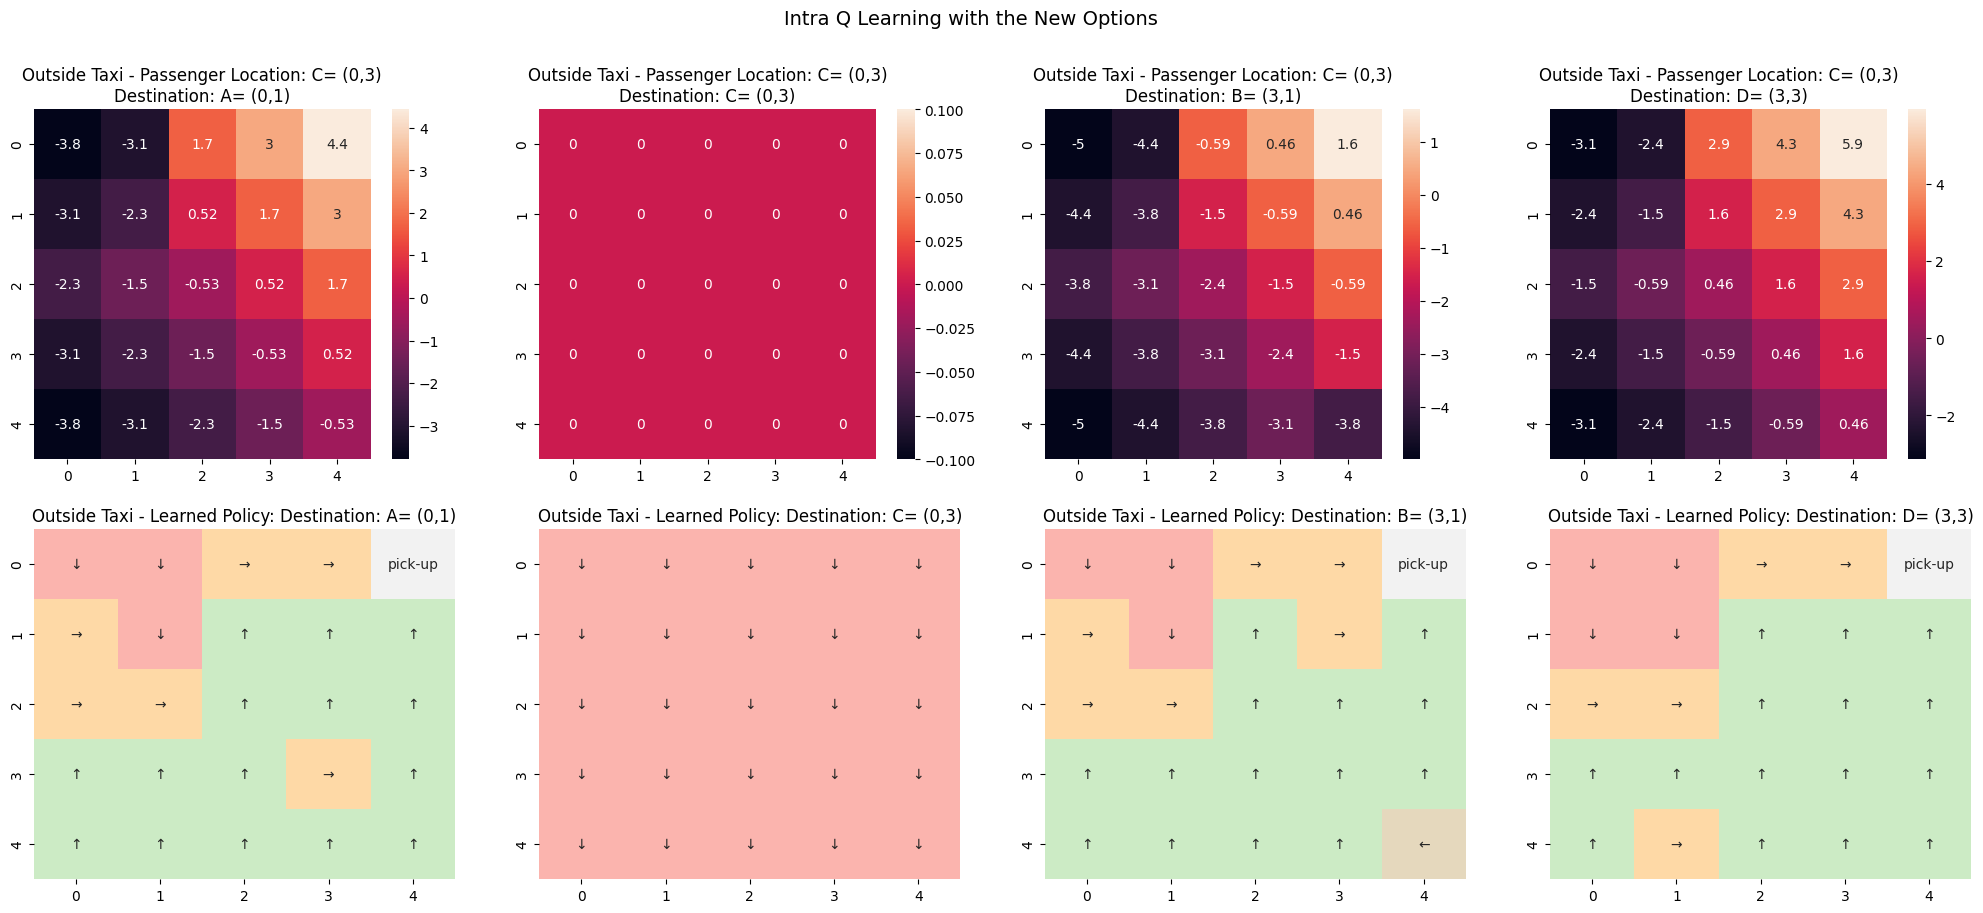

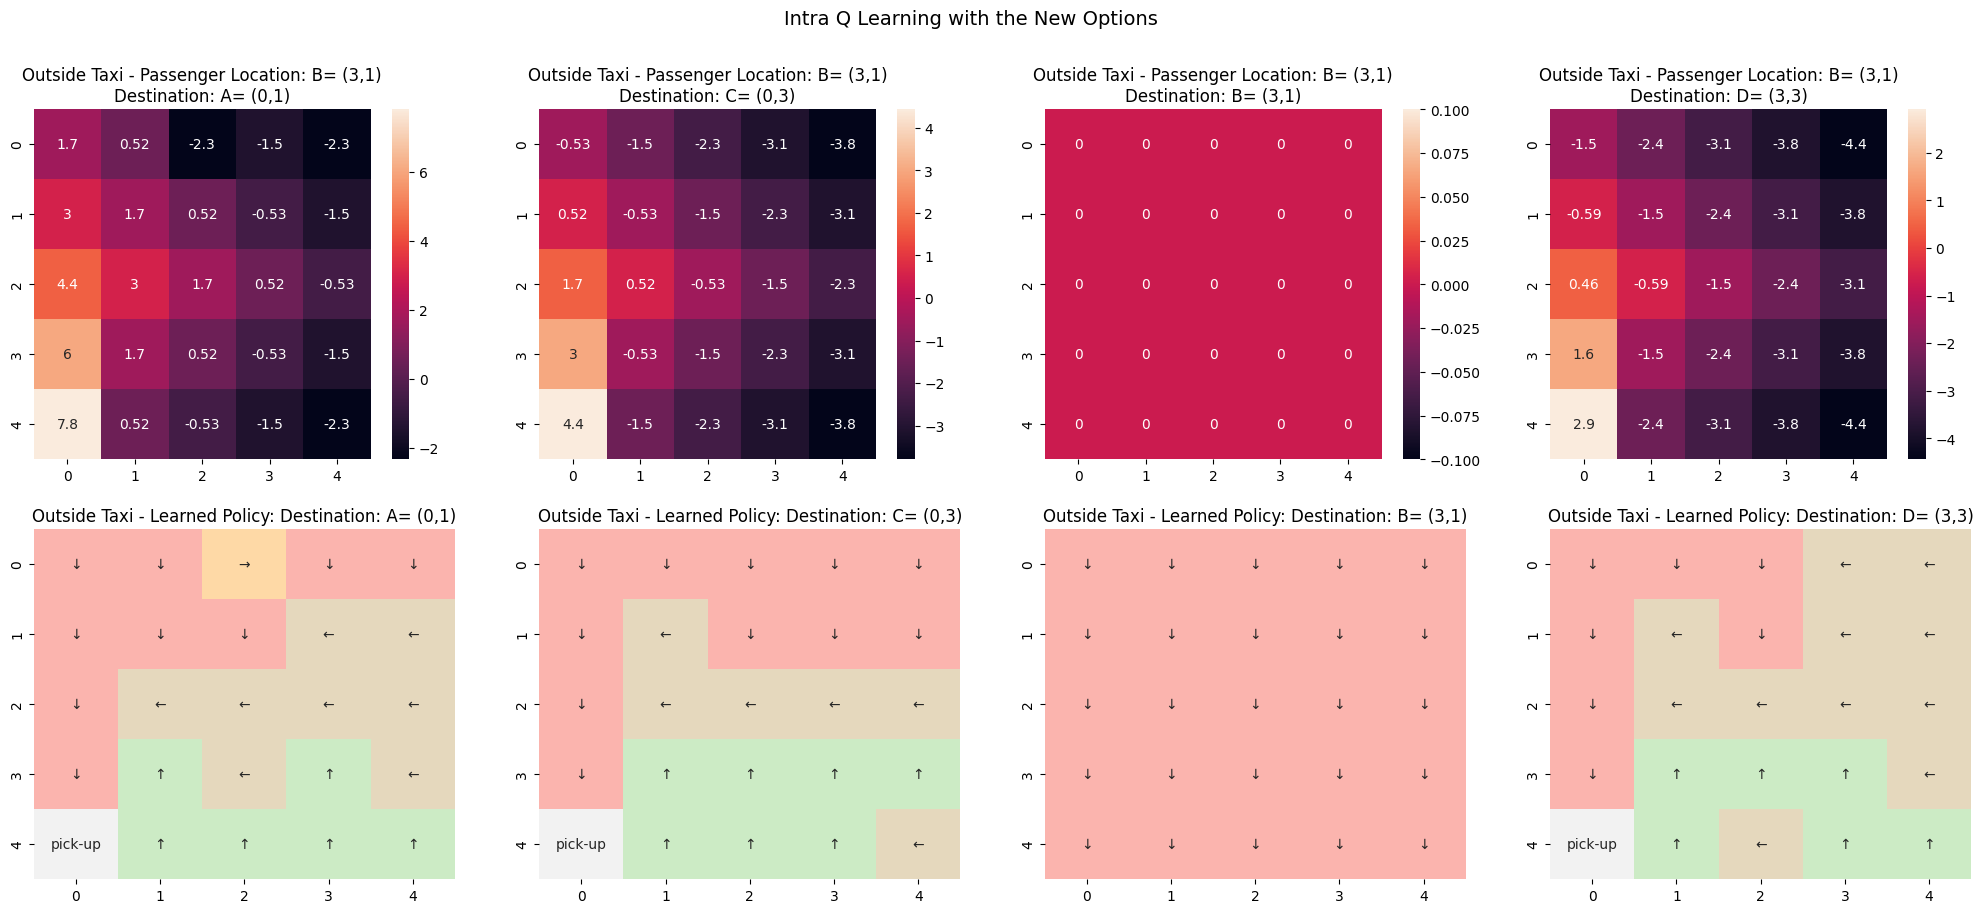

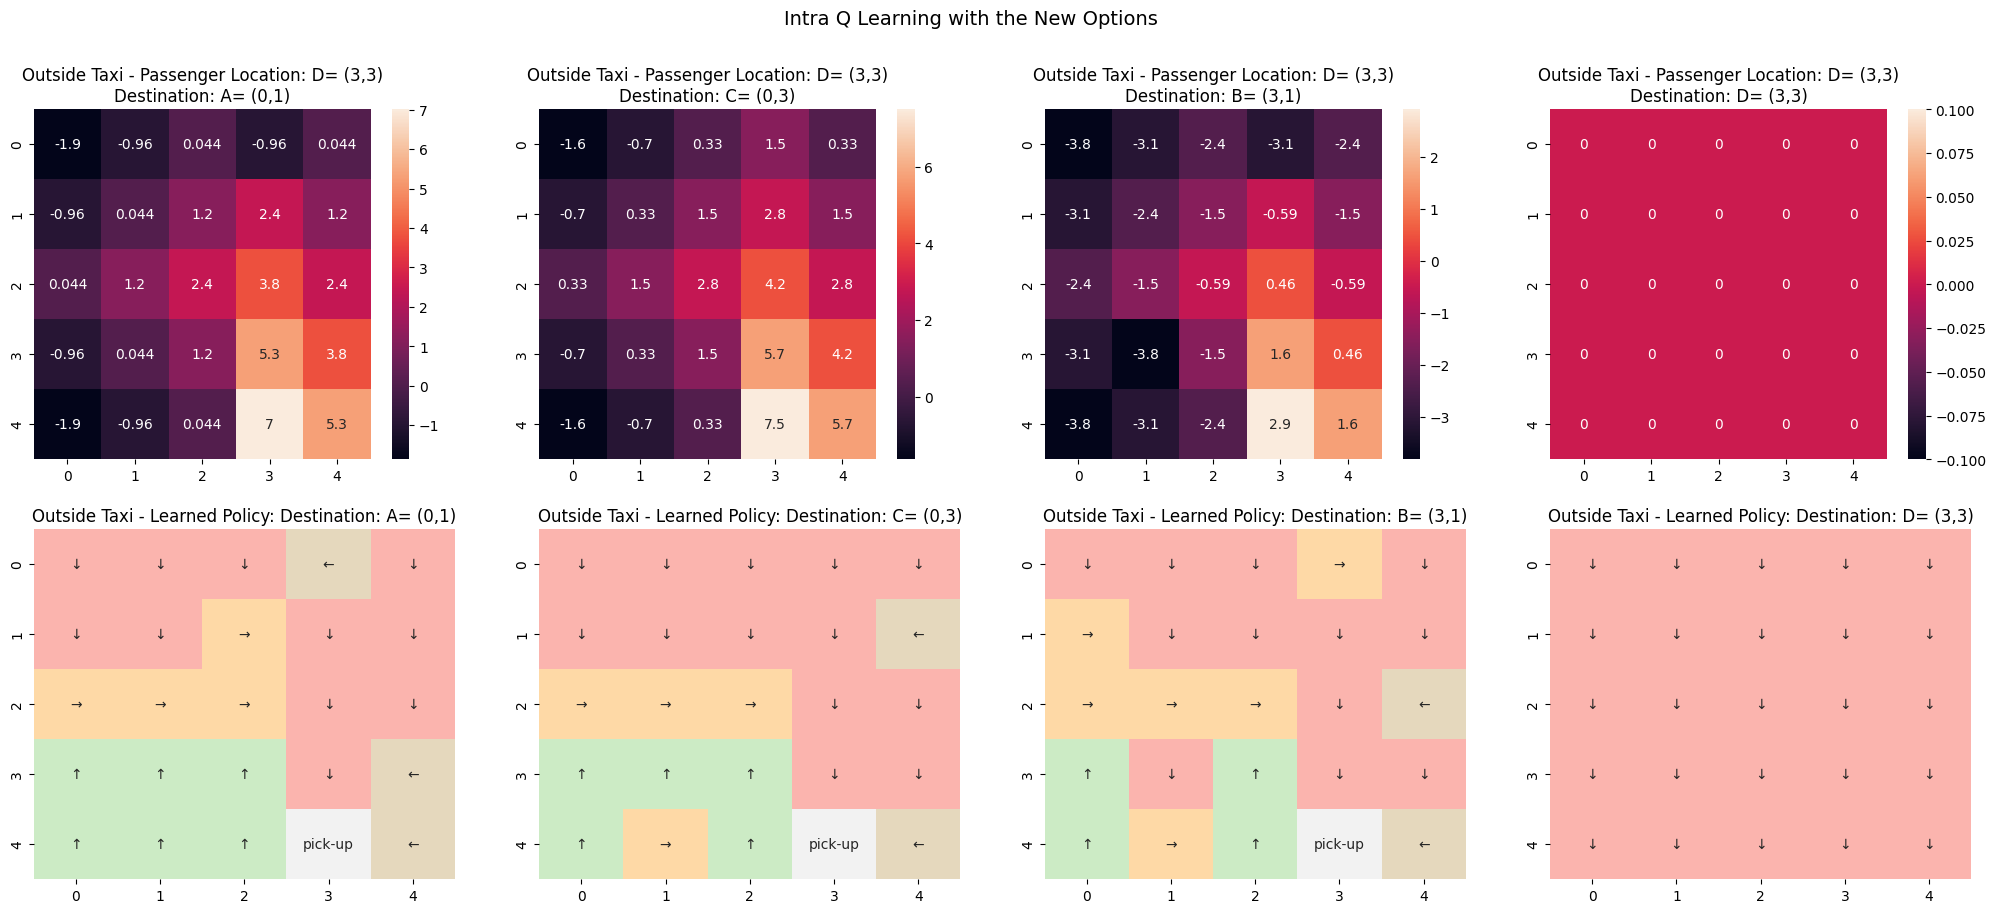

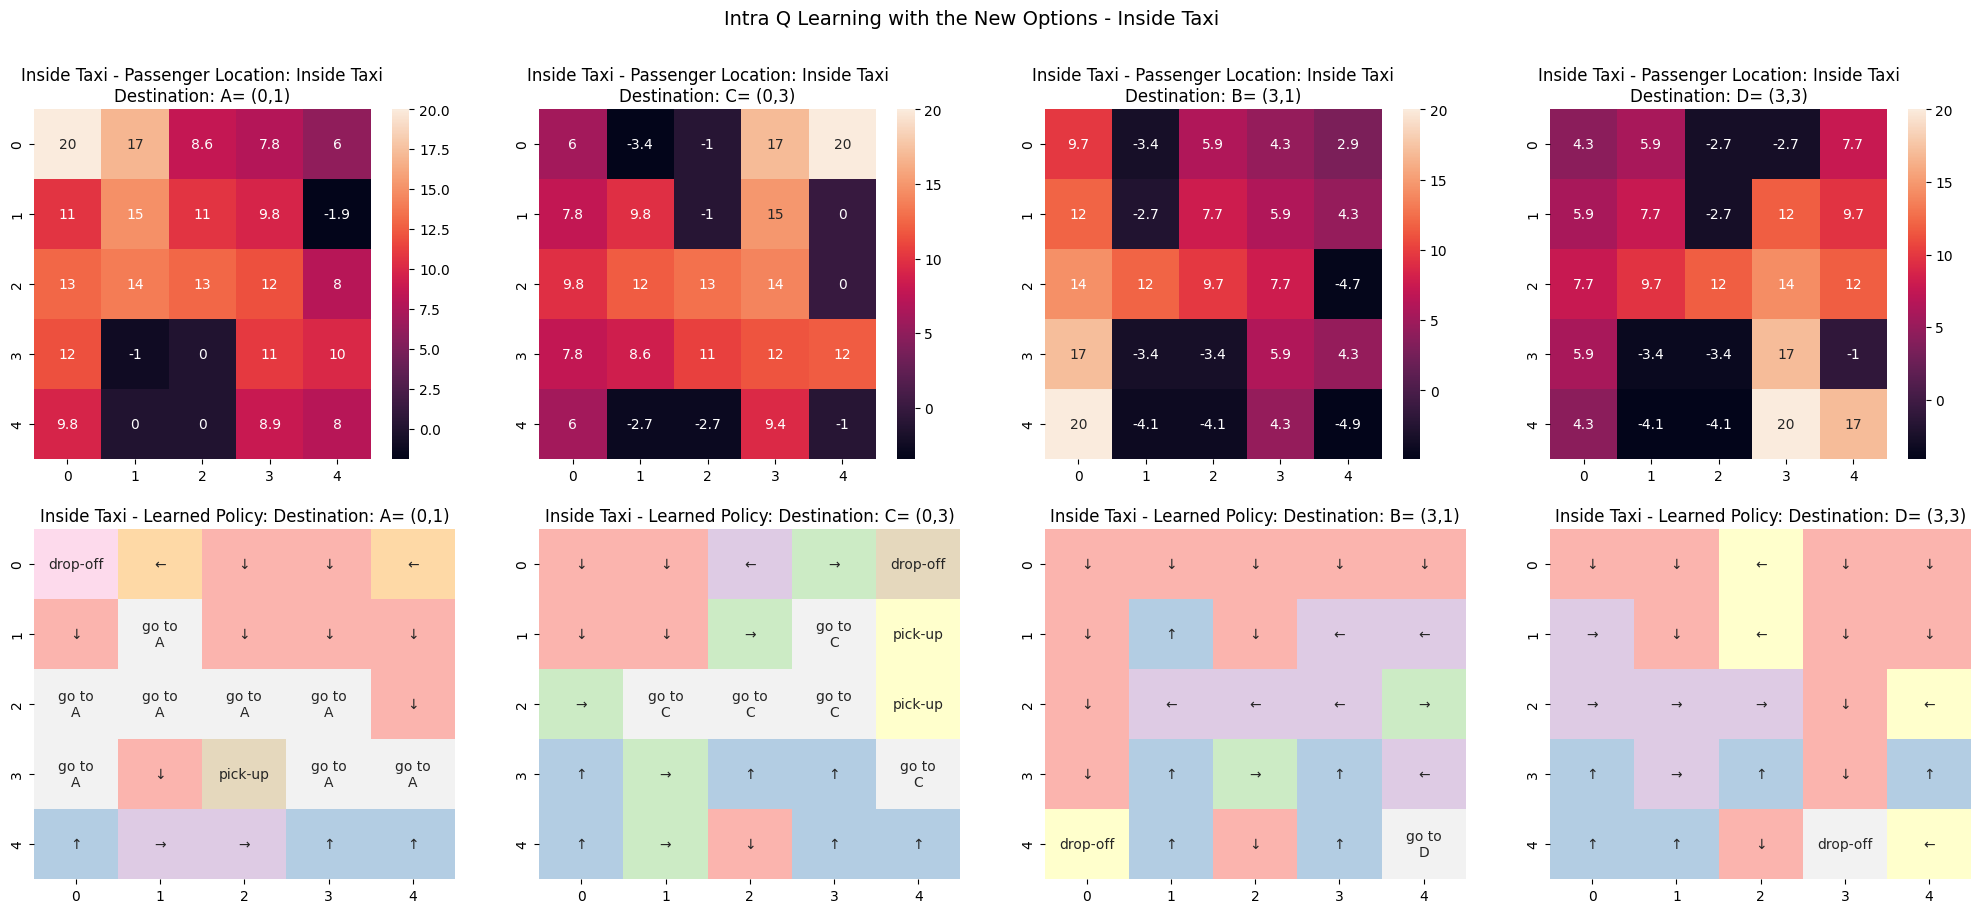

In [35]:
location = [0, 1, 2, 3]
subtitle = 'Intra Q Learning with the New Options'
actions = {0: '↓', 1: '↑', 2: '→', 3: '←',4: 'pick-up', 5: 'drop-off', 6: 'go to\nA', 7: 'go to\nC', 8: 'go to\nB', 9: 'go to\nD'}
pass_loc = {0: 'A= (0,1)', 1: 'C= (0,3)', 2: 'B= (3,1)', 3: 'D= (3,3)'}
for i in range(4):
    vis_Q_smdp_intra(i,subtitle , env, new_Q_intra, actions, pass_loc)

### Comparision of rewards for new options


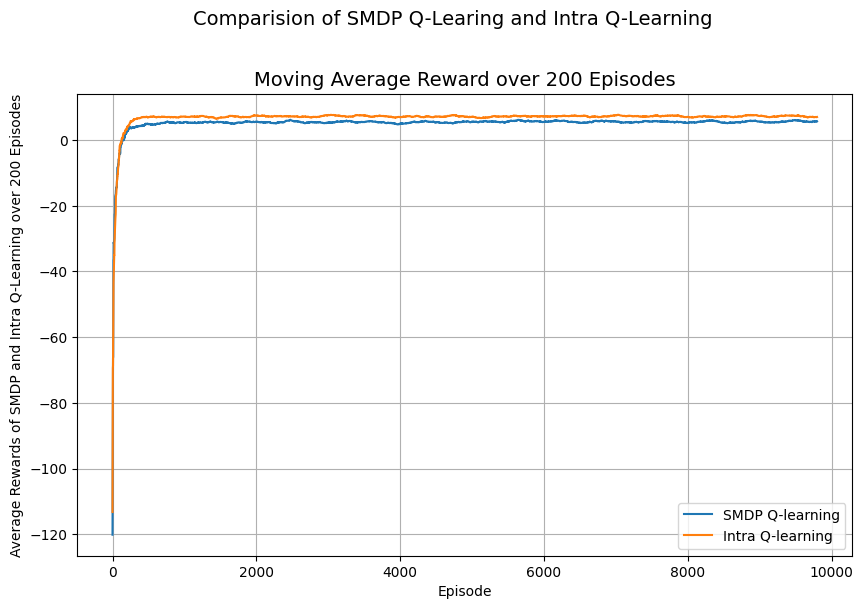

In [36]:
# rewards comparision for SMDP and Intra Q-learning
average_rewards_comp(new_rewards_smdp, new_rewards_intra, num_episodes)

### Analysis for an alternate set of options

New set of options with the coordinates given by, A = (0,1), B = (3,1), C = (0,3), and D = (3,3)

**Explanation:** 
- These new options are mutually exclusive with the provided set because
- They define different specific locations within the grid,
- They constitute a different strategic approach in how the agent navigates its environment,
- They change the sub-goal structure of the problem that is it changes how the agent decomposes the overall task.

#### **Comparison with Performance of New Options:**

**SMDP Q Learning with new options:**

- The reward curve shows a high initial variance that is indicative of unstable learning in early episodes.
- In time, the algorithm starts to stabilize and creates an upward trend in average reward.
- The patterns are learned in Q-value heatmaps to describe navigation to the new locations A, B, C, and D.

**Intra-option Q-Learning with new options:**

- The reward curve exhibits a faster initial improvement compared to SMDP Q-Learning.
- Demonstrates more consistent learning with less variance in rewards across episodes.
- Q-value visualizations show clear policy towards reaching new destination points.

**Both algorithms adapted well to the new option set but the intra-option Q-Learning seemed to learn more efficiently and in a stable way.**

## Comparision and Summary

### Comparision

#### **Comparison:**

- **Learning speed:**

    - SMDP Q-Learning: Shows a gradual improvement in rewards over episodes.
    - Intra-option Q-Learning: Demonstrates a steeper initial learning curve, indicating faster policy improvement.

- **Stability:**

    - SMDP Q-Learning: Exhibits more variance in rewards, especially in earlier episodes.
    - Intra-option Q-Learning: Shows a more stable learning progression with less fluctuation in rewards.

- **Final performance:**

    - Both algorithms eventually reach similar levels of performance in terms of average reward.
    - Intra-option Q-Learning appears to converge to this level more quickly.

- **Adaptability:**

    - Both algorithms successfully adapted to the new option set, showing the flexibility of these methods.
    - Intra-option Q-Learning seemed to adapt more quickly to the changed environment structure.

- **Improvement observed with intra-option Q-Learning:**

    - Faster initial learning.
    - More stable learning progression.
    - Potentially quicker convergence to optimal policy.

#### **Reasons for this improvement:**

- **Parallel updates:**

    - Intra-option Q-Learning updates Q-values for multiple options simultaneously.
    - This allows for more efficient use of each interaction with the environment.

- **Information leverage:**

    - It extracts information about multiple options from a single experience.
    - This leads to faster propagation of value information through the state-action space.

- **Reduced exploration requirements:**

    - By learning about multiple options at once, it effectively reduces the exploration needed to converge on an optimal policy.
    - This results in more data-efficient learning.

- **Off-policy learning:**

    - Intra-option Q-Learning can update options that weren't actually executed, allowing for off-policy learning.
    - This further accelerates the learning process by extracting more information from each experience.

### Summary

**Policy Learning:**

- Both SMDP Q-Learning and intra-option Q-Learning successfully learned policies for the taxi domain problem.
- The policies efficiently navigate the taxi, handle pickups and dropoffs, and avoid illegal actions.
- Learning is achieved through iterative updates of Q-values based on rewards and state transitions.


**Alternate Options:**

- An alternate set of options (A, B, C, D) was introduced, mutually exclusive with the original set.
- Both algorithms adapted to these new options, demonstrating flexibility.
- Intra-option Q-Learning showed faster adaptation and more stable learning with the new options.

**Algorithm Comparison:**

- ***SMDP Q-Learning:***

    - Updates policy based on chosen options.
    - Shows gradual improvement but with higher initial variance.
    - Effective but potentially slower in complex environments.

- **Intra-option Q-Learning:**

    - Updates multiple options simultaneously.
    - Demonstrates faster initial learning and more stable progression.
    - More efficient in using each interaction with the environment.

**Observed Improvements:**

Intra-option Q-Learning showed notable improvements in:

- Learning speed.
- Stability of learning curve.
- Efficiency of convergence to optimal policy.
